# GCP BigQuery Setup

### Required installations 

In [94]:
!python -V

/bin/bash: line 1: python: command not found


In [95]:
!pip install --upgrade bigframes
!pip install google-cloud-bigquery

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [96]:
!pip install modin
!pip install polars

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [97]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Defining .json with key to access data in GCP

In [98]:
import os
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "bqproject-461521-eacb4f49ba0b.json"

client = bigquery.Client()

In [99]:
import bigframes as bf
import bigframes.pandas as bpd

import matplotlib as plt 

###  Load table from BigQuery with performance timing

In [100]:
import time

def load_bigquery_table(table_name, dataset="ICU", project="bqproject-461521"):
    """
    Load a BigQuery table into a pandas DataFrame with timing.

    Args:
        table_name (str): Nome da tabela no dataset (sem prefixo)
        dataset (str): Nome do dataset (default = "ICU")
        project (str): Nome do projeto GCP (default = "bqproject-461521")

    Returns:
        pandas.DataFrame
    """
    full_table = f"{project}.{dataset}.{table_name}"
    print(f"Loading {full_table} from BigQuery...")
    
    start_time = time.time()
    query = f"SELECT * FROM `{full_table}`"
    df = client.query(query).to_dataframe()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {len(df)} rows in {end_time - start_time:.2f} seconds\n")
    return df


### Calculate loading time for each initial table in the bucket 

In [101]:
init_time = time.time()

admissions_df = load_bigquery_table("tab_admissions")
callout_df = load_bigquery_table("tab_callout")
icustays_df = load_bigquery_table("tab_icuStays")
patients_df = load_bigquery_table("tab_Patients")
services_df = load_bigquery_table("tab_services")
transfers_df = load_bigquery_table("tab_transfers")

final_time = time.time() - init_time
print(f"Total loading time: {final_time:.2f} seconds")


Loading bqproject-461521.ICU.tab_admissions from BigQuery...
Loaded tab_admissions: 58976 rows in 3.74 seconds

Loading bqproject-461521.ICU.tab_callout from BigQuery...
Loaded tab_callout: 34499 rows in 2.82 seconds

Loading bqproject-461521.ICU.tab_icuStays from BigQuery...
Loaded tab_icuStays: 61532 rows in 2.27 seconds

Loading bqproject-461521.ICU.tab_Patients from BigQuery...
Loaded tab_Patients: 46520 rows in 1.91 seconds

Loading bqproject-461521.ICU.tab_services from BigQuery...
Loaded tab_services: 73343 rows in 1.96 seconds

Loading bqproject-461521.ICU.tab_transfers from BigQuery...
Loaded tab_transfers: 261897 rows in 3.11 seconds

Total loading time: 15.82 seconds


In [102]:
admissions_df.head(5)

ROW_ID  SUBJECT_ID  HADM_ID                 ADMITTIME  \
0    4060        3369   126808 2111-01-24 11:53:00+00:00   
1   50952       74869   123152 2150-09-05 17:49:00+00:00   
2   12812       10484   113233 2190-09-18 22:39:00+00:00   
3   13573       11091   164694 2101-06-07 13:57:00+00:00   
4   33654       27527   155091 2131-08-27 18:01:00+00:00   

                  DISCHTIME                 DEATHTIME ADMISSION_TYPE  \
0 2111-01-25 22:40:00+00:00 2111-01-25 22:40:00+00:00      EMERGENCY   
1 2150-09-12 18:30:00+00:00 2150-09-12 18:30:00+00:00      EMERGENCY   
2 2190-09-24 20:40:00+00:00 2190-09-24 20:40:00+00:00      EMERGENCY   
3 2101-09-18 07:20:00+00:00 2101-09-18 07:20:00+00:00      EMERGENCY   
4 2131-10-03 05:30:00+00:00 2131-10-03 05:30:00+00:00      EMERGENCY   

          ADMISSION_LOCATION DISCHARGE_LOCATION INSURANCE LANGUAGE  \
0  PHYS REFERRAL/NORMAL DELI       DEAD/EXPIRED   Private     None   
1  TRANSFER FROM HOSP/EXTRAM       DEAD/EXPIRED  Medicare     ENGL   
2  TRANSFER FROM HOSP/EXTRAM       DEAD/EXPIRED  Medicaid     None   
3  CLINIC REFERRAL/PREMATURE       DEAD/EXPIRED   Private     None   
4  CLINIC REFERRAL/PREMATURE       DEAD/EXPIRED   Private     PTUN   

        RELIGION MARITAL_STATUS         ETHNICITY EDREGTIME EDOUTTIME  \
0   UNOBTAINABLE         SINGLE             WHITE       NaT       NaT   
1       CATHOLIC        WIDOWED  ASIAN - JAPANESE       NaT       NaT   
2       CATHOLIC        MARRIED             WHITE       NaT       NaT   
3       CATHOLIC      SEPARATED             WHITE       NaT       NaT   
4  NOT SPECIFIED        MARRIED             WHITE       NaT       NaT   

                          DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                              None                     1   
1              ? SEROTONIN SYNDROME                     1   
2  (AML) ACUTE MYELOGENOUS LEUKEMIA                     1   
3  (AML) ACUTE MYELOGENOUS LEUKEMIA                     1   
4  (AML) ACUTE MYELOGENOUS LEUKEMIA                     1   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

### Utility Functions for Executing Queries

These functions simplify running queries on BigQuery:
- `run_query_scalar(query)`: Executes a query and returns the first value (useful for simple aggregations like `COUNT`, `MAX`, etc.).
- `run_query_list(query)`: Executes a query and returns all results as a list of dictionaries.


In [103]:
def run_query_scalar(query):
    result = client.query(query).result()
    return list(result)[0][0]

def run_query_list(query):
    result = client.query(query).result()
    return [dict(row) for row in result]

### Analysis of Multiple ICU Stays

This section analyzes patterns of multiple ICU admissions:
- Counts the total number of ICU stays, unique patients, and hospital admissions.
- Identifies patients and admissions with more than one ICU stay.
- Displays the distribution of ICU stays per patient.
- Shows example records of patients with multiple ICU stays, including admission/discharge times and length of stay.


In [106]:
print("=== Analysis of Multiple ICU Stays (BigQuery) ===\n")

# Total ICU stays
total_stays = run_query_scalar("""
    SELECT COUNT(*) as total_stays
    FROM `bqproject-461521.ICU.tab_icuStays`
""")
print(f"Total ICU stays: {total_stays}")

# Unique patients
unique_patients = run_query_scalar("""
    SELECT COUNT(DISTINCT SUBJECT_ID) as unique_patients
    FROM `bqproject-461521.ICU.tab_icuStays`
""")
print(f"Unique patients: {unique_patients}")

# Unique admissions
unique_admissions = run_query_scalar("""
    SELECT COUNT(DISTINCT HADM_ID) as unique_admissions
    FROM `bqproject-461521.ICU.tab_icuStays`
""")
print(f"Unique hospital admissions: {unique_admissions}")

# Patients with multiple ICU stays
patients_multiple_stays_count = run_query_scalar("""
    SELECT COUNT(*) FROM (
        SELECT SUBJECT_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")
print(f"Patients with multiple ICU stays: {patients_multiple_stays_count}")

# Admissions with multiple ICU stays
same_admission_count = run_query_scalar("""
    SELECT COUNT(*) FROM (
        SELECT HADM_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY HADM_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")
print(f"Hospital admissions with multiple ICU stays: {same_admission_count}")

# Distribution of ICU stays per patient
print("\nDistribution of ICU stays per patient:")
distribution = run_query_list("""
    SELECT stays_count, COUNT(*) AS patient_count
    FROM (
        SELECT SUBJECT_ID, COUNT(ICUSTAY_ID) as stays_count
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
    )
    GROUP BY stays_count
    ORDER BY stays_count
""")
for row in distribution:
    print(f"{row['stays_count']} stay(s): {row['patient_count']} patient(s)")

# Example rows of patients with multiple ICU stays
print("\nExamples of patients with multiple ICU stays:")
example_rows = run_query_list("""
    WITH multiple AS (
        SELECT SUBJECT_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
    SELECT SUBJECT_ID, HADM_ID, ICUSTAY_ID, INTIME, OUTTIME, LOS
    FROM `bqproject-461521.ICU.tab_icuStays`
    WHERE SUBJECT_ID IN (SELECT SUBJECT_ID FROM multiple)
    ORDER BY SUBJECT_ID, INTIME
    LIMIT 20  -- Limit results to avoid too much output
""")

for row in example_rows:
    # Handle None values for LOS
    los_value = row['LOS'] if row['LOS'] is not None else 'NULL'
    los_formatted = f"{los_value:.2f}" if row['LOS'] is not None else 'NULL'
    
    print(f"SUBJECT_ID: {row['SUBJECT_ID']}, HADM_ID: {row['HADM_ID']}, ICUSTAY_ID: {row['ICUSTAY_ID']}, "
          f"INTIME: {row['INTIME']}, OUTTIME: {row['OUTTIME']}, LOS: {los_formatted}")

# Check for NULL LOS values
null_los_count = run_query_scalar("""
    SELECT COUNT(*) 
    FROM `bqproject-461521.ICU.tab_icuStays`
    WHERE LOS IS NULL
""")
print(f"\nICU stays with NULL LOS values: {null_los_count}")

=== Analysis of Multiple ICU Stays (BigQuery) ===

Total ICU stays: 61532
Unique patients: 46476
Unique hospital admissions: 57786
Patients with multiple ICU stays: 8755
Hospital admissions with multiple ICU stays: 3260

Distribution of ICU stays per patient:
1 stay(s): 37721 patient(s)
2 stay(s): 5796 patient(s)
3 stay(s): 1619 patient(s)
4 stay(s): 650 patient(s)
5 stay(s): 300 patient(s)
6 stay(s): 151 patient(s)
7 stay(s): 86 patient(s)
8 stay(s): 44 patient(s)
9 stay(s): 29 patient(s)
10 stay(s): 19 patient(s)
11 stay(s): 15 patient(s)
12 stay(s): 11 patient(s)
13 stay(s): 8 patient(s)
14 stay(s): 4 patient(s)
15 stay(s): 6 patient(s)
16 stay(s): 2 patient(s)
17 stay(s): 2 patient(s)
18 stay(s): 2 patient(s)
20 stay(s): 1 patient(s)
21 stay(s): 2 patient(s)
22 stay(s): 1 patient(s)
23 stay(s): 1 patient(s)
25 stay(s): 2 patient(s)
31 stay(s): 1 patient(s)
35 stay(s): 1 patient(s)
38 stay(s): 1 patient(s)
41 stay(s): 1 patient(s)

Examples of patients with multiple ICU stays:
SUBJE

### ICU Stay Statistics Overview

This cell retrieves and visualizes key statistics from the ICU stays dataset in BigQuery:
- Total number of ICU stays
- Number of unique patients
- Number of patients with multiple ICU stays
- Number of hospital admissions involving multiple ICU stays

The data is presented in a bar chart for quick visual comparison.


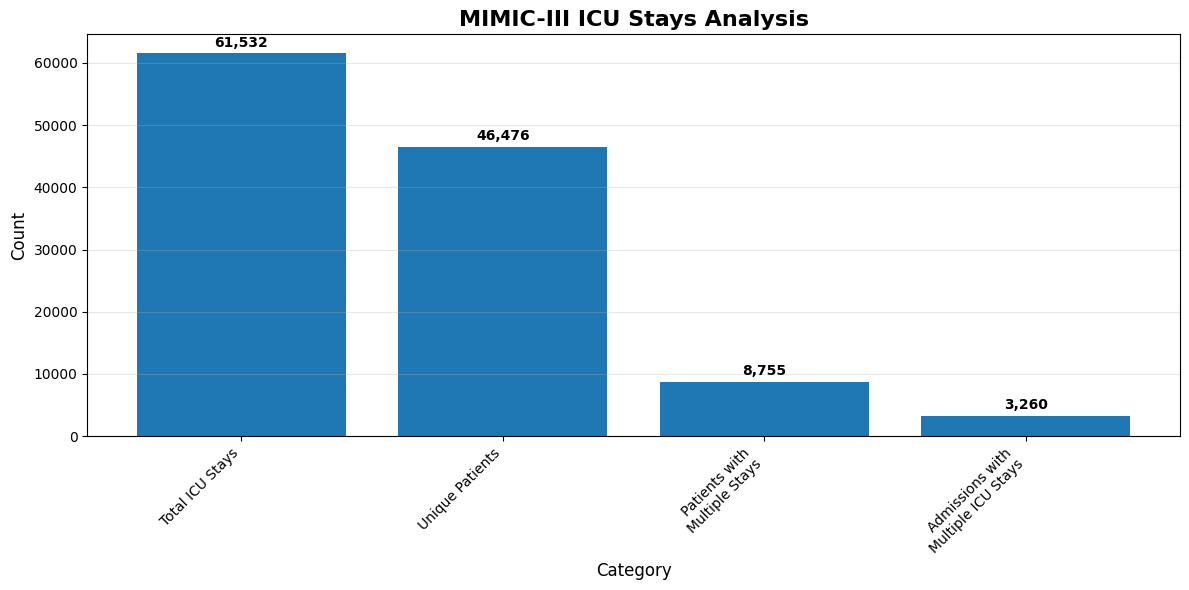

In [107]:
from google.cloud import bigquery
import matplotlib.pyplot as plt

client = bigquery.Client()

def get_scalar(query):
    return list(client.query(query).result())[0][0]

# Obter os valores diretamente de BigQuery
total_stays = get_scalar("SELECT COUNT(*) FROM `bqproject-461521.ICU.tab_icuStays`")
unique_patients = get_scalar("SELECT COUNT(DISTINCT SUBJECT_ID) FROM `bqproject-461521.ICU.tab_icuStays`")
patients_with_multiple_stays = get_scalar("""
    SELECT COUNT(*) FROM (
        SELECT SUBJECT_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY SUBJECT_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")
admissions_with_multiple_icu_stays = get_scalar("""
    SELECT COUNT(*) FROM (
        SELECT HADM_ID
        FROM `bqproject-461521.ICU.tab_icuStays`
        GROUP BY HADM_ID
        HAVING COUNT(ICUSTAY_ID) > 1
    )
""")

# Preparar os dados para o gráfico
labels = ['Total ICU Stays', 'Unique Patients', 'Patients with\nMultiple Stays', 'Admissions with\nMultiple ICU Stays']
values = [
    total_stays,
    unique_patients,
    patients_with_multiple_stays,
    admissions_with_multiple_icu_stays
]

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values)

# Adicionar os valores acima de cada barra
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Personalizações
plt.title('MIMIC-III ICU Stays Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [108]:
stats = {
    "total_stays": total_stays,
    "unique_patients": unique_patients,
    "patients_with_multiple_stays": patients_with_multiple_stays,
    "admissions_with_multiple_icu_stays": admissions_with_multiple_icu_stays
}
print(stats)


{'total_stays': 61532, 'unique_patients': 46476, 'patients_with_multiple_stays': 8755, 'admissions_with_multiple_icu_stays': 3260}


### Let's join ICUSTAYS and ADMISSIONS table to get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't


In [109]:
# Destination table name
destination_table = "bqproject-461521.ICU.tab_icu_with_admissions"

# Query that generates the joined result
query = """
SELECT
  i.*,
  a.ADMITTIME,
  a.DISCHTIME,
  a.DEATHTIME,
  a.ETHNICITY,
  a.DIAGNOSIS,
  a.ADMISSION_TYPE,
  a.ADMISSION_LOCATION,
  a.DISCHARGE_LOCATION,
  a.INSURANCE,
  a.LANGUAGE,
  a.MARITAL_STATUS,
  a.RELIGION
FROM
  `bqproject-461521.ICU.tab_icuStays` AS i
LEFT JOIN
  `bqproject-461521.ICU.tab_admissions` AS a
ON
  i.SUBJECT_ID = a.SUBJECT_ID
  AND i.HADM_ID = a.HADM_ID
"""

# Define the job config to create a new table
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"  # Overwrites the table if it exists
)

# Run the query and wait for completion
query_job = client.query(query, job_config=job_config)
query_job.result()  # Wait for job to finish

print(f"Table created: {destination_table}")


Table created: bqproject-461521.ICU.tab_icu_with_admissions


In [110]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_with_admissions`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 519, 'SUBJECT_ID': 389, 'HADM_ID': 134048, 'ICUSTAY_ID': 220654, 'DBSOURCE': 'carevue', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIME': datetime.datetime(2104, 4, 18, 1, 36, 24, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2104, 4, 19, 16, 17, 9, tzinfo=datetime.timezone.utc), 'LOS': 1.6116, 'ADMITTIME': datetime.datetime(2104, 4, 18, 1, 34, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2104, 4, 28, 15, 6, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ETHNICITY': 'WHITE', 'DIAGNOSIS': 'LOWER', 'ADMISSION_TYPE': 'EMERGENCY', 'ADMISSION_LOCATION': 'EMERGENCY ROOM ADMIT', 'DISCHARGE_LOCATION': 'HOME HEALTH CARE', 'INSURANCE': 'Medicare', 'LANGUAGE': None, 'MARITAL_STATUS': 'MARRIED', 'RELIGION': 'JEWISH'}
{'ROW_ID': 2120, 'SUBJECT_ID': 1676, 'HADM_ID': 138230, 'ICUSTAY_ID': 271990, 'DBSOURCE': 'carevue', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIM

In [161]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_with_admissions`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_with_admissions: {total:,}")


Total entries in tab_icu_with_admissions: 61,532


#### Now we join the complete ICU data with the PATIENTS info


In [112]:
# Destination table name for the full joined data
destination_table = "bqproject-461521.ICU.tab_icu_full_patient_info"

# Join query
query = """
SELECT
  icu.*,
  p.GENDER,
  p.DOB,
  p.DOD,
  p.DOD_HOSP,
  p.DOD_SSN,
  p.EXPIRE_FLAG
FROM
  `bqproject-461521.ICU.tab_icu_with_admissions` AS icu
LEFT JOIN
  `bqproject-461521.ICU.tab_Patients` AS p
ON
  icu.SUBJECT_ID = p.SUBJECT_ID
"""

# Define job config to write results to a table
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"  # Overwrites the table if it exists
)

# Run and wait for completion
query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Table created: {destination_table}")


Table created: bqproject-461521.ICU.tab_icu_full_patient_info


In [113]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_full_patient_info`
LIMIT 5
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 55141, 'SUBJECT_ID': 80891, 'HADM_ID': 196778, 'ICUSTAY_ID': 268185, 'DBSOURCE': 'metavision', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIME': datetime.datetime(2131, 10, 7, 11, 57, 5, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2131, 10, 12, 22, 31, 30, tzinfo=datetime.timezone.utc), 'LOS': 5.4406, 'ADMITTIME': datetime.datetime(2131, 10, 7, 8, 58, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2131, 10, 14, 14, 25, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ETHNICITY': 'HISPANIC OR LATINO', 'DIAGNOSIS': ' STEMI', 'ADMISSION_TYPE': 'EMERGENCY', 'ADMISSION_LOCATION': 'TRANSFER FROM HOSP/EXTRAM', 'DISCHARGE_LOCATION': 'HOME HEALTH CARE', 'INSURANCE': 'Government', 'LANGUAGE': 'ENGL', 'MARITAL_STATUS': 'DIVORCED', 'RELIGION': 'CATHOLIC', 'GENDER': 'F', 'DOB': datetime.datetime(2075, 6, 24, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': None, 'DOD_HOSP': None, 'DOD_SSN': None, 'EXPIRE_FLAG': 0}


In [160]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_full_patient_info`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_full_patient_info: {total:,}")


Total entries in tab_icu_full_patient_info: 61,532


#### join the DIAGNOSES and D_ICD_DIAGNOSES tables to get diagnoses descriptions based on the ICD9 code



In [115]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_d_icd_diagnoses`
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 5120, 'ICD9_CODE': '4957', 'SHORT_TITLE': '"ventilation" pneumonit', 'LONG_TITLE': '"Ventilation" pneumonitis'}
{'ROW_ID': 11159, 'ICD9_CODE': '94416', 'SHORT_TITLE': '1 deg burn back of hand', 'LONG_TITLE': 'Erythema [first degree] of back of hand'}
{'ROW_ID': 11157, 'ICD9_CODE': '94414', 'SHORT_TITLE': '1 deg burn fingr w thumb', 'LONG_TITLE': 'Erythema [first degree] of two or more digits of hand including thumb'}
{'ROW_ID': 3658, 'ICD9_CODE': '36911', 'SHORT_TITLE': '1 eye-sev/oth-blind NOS', 'LONG_TITLE': 'Better eye: severe vision impairment; lesser eye: blind, not further specified'}
{'ROW_ID': 12505, 'ICD9_CODE': '94811', 'SHORT_TITLE': '10-19% bdy brn/10-19% 3d', 'LONG_TITLE': 'Burn [any degree] involving 10-19 percent of body surface with third degree burn, 10-19%'}
{'ROW_ID': 12504, 'ICD9_CODE': '94810', 'SHORT_TITLE': '10-19% bdy brn/3 deg NOS', 'LONG_TITLE': 'Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent o

In [116]:
# Destination table
destination_table = "bqproject-461521.ICU.tab_diagnoses_full"

# Query to join and exclude SHORT_TITLE
query = """
SELECT
  d.*,
  dd.LONG_TITLE
FROM
  `bqproject-461521.ICU.tab_diagnoses` AS d
LEFT JOIN
  `bqproject-461521.ICU.tab_d_icd_diagnoses` AS dd
ON
  d.ICD9_CODE = dd.ICD9_CODE

  
"""

# Configure job to write to new table
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"
)

# Execute query and wait
query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Table created: {destination_table}")


Table created: bqproject-461521.ICU.tab_diagnoses_full


In [117]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_diagnoses_full`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 7969, 'SUBJECT_ID': 690, 'HADM_ID': 174817, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 10924, 'SUBJECT_ID': 937, 'HADM_ID': 177274, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 84252, 'SUBJECT_ID': 7544, 'HADM_ID': 116945, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 298691, 'SUBJECT_ID': 26690, 'HADM_ID': 196643, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 110935, 'SUBJECT_ID': 9896, 'HADM_ID': 171183, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 180428, 'SUBJECT_ID': 16213, 'HADM_ID': 199739, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 148860, 'SUBJECT_ID': 13262, 'HADM_ID': 160049, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 206919, 'SUBJECT_ID': 18605, 'HADM_ID': 144751, 'SEQ_NUM': None, 'ICD9_CODE': None, 'LONG_TITLE': None}
{'ROW_ID': 45143, 'SUBJECT_ID': 4023, 'HADM_ID': 170307, 'SEQ_NUM': None, 'ICD9_CODE': Non

In [159]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_diagnoses_full`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_diagnoses_full: {total:,}")


Total entries in tab_diagnoses_full: 651,047


#### Now the PATIENT and DIAGNOSES data

In [119]:
# Nome da tabela destino
destination_table = "bqproject-461521.ICU.tab_icu_full_with_diagnoses"

# Query para juntar PATIENT + DIAGNOSES
query = """
SELECT
  p.*,
  d.ICD9_CODE,
  d.LONG_TITLE
FROM
  `bqproject-461521.ICU.tab_icu_full_patient_info` AS p
LEFT JOIN
  `bqproject-461521.ICU.tab_diagnoses_full` AS d
ON
  p.SUBJECT_ID = d.SUBJECT_ID
  AND p.HADM_ID = d.HADM_ID
"""

# Configurar job para gravar tabela
job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"
)

# Executar e aguardar conclusão
query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Tabela criada com sucesso: {destination_table}")

Tabela criada com sucesso: bqproject-461521.ICU.tab_icu_full_with_diagnoses


In [120]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 17, 'SUBJECT_ID': 18, 'HADM_ID': 188822, 'ICUSTAY_ID': 298129, 'DBSOURCE': 'carevue', 'FIRST_CAREUNIT': 'CCU', 'LAST_CAREUNIT': 'CCU', 'FIRST_WARDID': 7, 'LAST_WARDID': 7, 'INTIME': datetime.datetime(2167, 10, 2, 11, 20, 39, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2167, 10, 3, 18, 16, 5, tzinfo=datetime.timezone.utc), 'LOS': 1.2885, 'ADMITTIME': datetime.datetime(2167, 10, 2, 11, 18, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2167, 10, 4, 16, 15, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ETHNICITY': 'WHITE', 'DIAGNOSIS': 'HYPOGLYCEMIA;SEIZURES', 'ADMISSION_TYPE': 'EMERGENCY', 'ADMISSION_LOCATION': 'PHYS REFERRAL/NORMAL DELI', 'DISCHARGE_LOCATION': 'HOME', 'INSURANCE': 'Private', 'LANGUAGE': None, 'MARITAL_STATUS': 'MARRIED', 'RELIGION': 'CATHOLIC', 'GENDER': 'M', 'DOB': datetime.datetime(2116, 11, 29, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': None, 'DOD_HOSP': None, 'DOD_SSN': None, 'EXPIRE_FLAG': 0, 'ICD9_CODE': '78039', 'LO

In [158]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_full_with_diagnoses: {total:,}")


Total entries in tab_icu_full_with_diagnoses: 705,921


### Binary Diagnosis Features from ICD-9 Codes

This cell creates a BigQuery table that maps ICD-9 codes to binary diagnostic categories (e.g., infectious, malignancy, cardiovascular, etc.). Each `ICUSTAY_ID` is assigned binary indicators based on the presence of ICD-9 codes falling within predefined ranges.

It also calculates the percentage of ICU stays that include at least one diagnosis in each category, helping to identify the most common types of conditions in the dataset.


In [157]:


# Fixed query with correct column name
create_diag_features_query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_icu_diag_features_complete` AS
WITH 
-- Step 1: Get base data (equivalent to base_data in PySpark)
base_data AS (
  SELECT DISTINCT
    ICUSTAY_ID,
    SUBJECT_ID,
    HADM_ID,
    INTIME,
    OUTTIME,
    LOS,
    ADMITTIME,
    DISCHTIME,
    DEATHTIME,
    ADMISSION_TYPE,
    DIAGNOSIS,  -- Fixed: Use DIAGNOSIS instead of ADMISSION_DIAGNOSIS
    GENDER,
    DOB,
    DOD,
    EXPIRE_FLAG
  FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
),

-- Step 2: Create diagnosis features from non-null ICD9_CODE records
diagnosis_binarized AS (
  SELECT
    ICUSTAY_ID,
    ICD9_CODE,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])'), 1, 0) AS has_infectious,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(1[4-9][0-9]|2[0-3][0-9])'), 1, 0) AS has_malignancy,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(2[4-7][0-9])'), 1, 0) AS has_endocrine,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(2[8-9][0-9])'), 1, 0) AS has_hematologic,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(29[0-9]|30[0-9]|31[0-9])'), 1, 0) AS has_psychiatric,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])'), 1, 0) AS has_neurological,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])'), 1, 0) AS has_cardiovascular,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])'), 1, 0) AS has_respiratory,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])'), 1, 0) AS has_gastrointestinal,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])'), 1, 0) AS has_genitourinary,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])'), 1, 0) AS has_obstetric,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(68[0-9]|69[0-9]|70[0-9])'), 1, 0) AS has_skin,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(71[0-9]|72[0-9]|73[0-9])'), 1, 0) AS has_musculoskeletal,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(74[0-9]|75[0-9])'), 1, 0) AS has_congenital,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(76[0-9]|77[0-9])'), 1, 0) AS has_perinatal,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(78[0-9]|79[0-9])'), 1, 0) AS has_symptoms_signs,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^(8[0-9][0-9]|9[0-9][0-9])'), 1, 0) AS has_trauma,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^E'), 1, 0) AS has_external_causes,
    IF(REGEXP_CONTAINS(ICD9_CODE, r'^V'), 1, 0) AS has_supplemental
  FROM `bqproject-461521.ICU.tab_icu_full_with_diagnoses`
  WHERE ICD9_CODE IS NOT NULL
),

-- Step 3: Aggregate diagnosis features by ICUSTAY_ID
diagnosis_features AS (
  SELECT
    ICUSTAY_ID,
    MAX(has_infectious) AS has_infectious,
    MAX(has_malignancy) AS has_malignancy,
    MAX(has_endocrine) AS has_endocrine,
    MAX(has_hematologic) AS has_hematologic,
    MAX(has_psychiatric) AS has_psychiatric,
    MAX(has_neurological) AS has_neurological,
    MAX(has_cardiovascular) AS has_cardiovascular,
    MAX(has_respiratory) AS has_respiratory,
    MAX(has_gastrointestinal) AS has_gastrointestinal,
    MAX(has_genitourinary) AS has_genitourinary,
    MAX(has_obstetric) AS has_obstetric,
    MAX(has_skin) AS has_skin,
    MAX(has_musculoskeletal) AS has_musculoskeletal,
    MAX(has_congenital) AS has_congenital,
    MAX(has_perinatal) AS has_perinatal,
    MAX(has_symptoms_signs) AS has_symptoms_signs,
    MAX(has_trauma) AS has_trauma,
    MAX(has_external_causes) AS has_external_causes,
    MAX(has_supplemental) AS has_supplemental,
    COUNT(ICD9_CODE) AS total_diagnoses
  FROM diagnosis_binarized
  GROUP BY ICUSTAY_ID
)

-- Step 4: Join base data with diagnosis features
SELECT 
  bd.*,
  COALESCE(df.has_infectious, 0) AS has_infectious,
  COALESCE(df.has_malignancy, 0) AS has_malignancy,
  COALESCE(df.has_endocrine, 0) AS has_endocrine,
  COALESCE(df.has_hematologic, 0) AS has_hematologic,
  COALESCE(df.has_psychiatric, 0) AS has_psychiatric,
  COALESCE(df.has_neurological, 0) AS has_neurological,
  COALESCE(df.has_cardiovascular, 0) AS has_cardiovascular,
  COALESCE(df.has_respiratory, 0) AS has_respiratory,
  COALESCE(df.has_gastrointestinal, 0) AS has_gastrointestinal,
  COALESCE(df.has_genitourinary, 0) AS has_genitourinary,
  COALESCE(df.has_obstetric, 0) AS has_obstetric,
  COALESCE(df.has_skin, 0) AS has_skin,
  COALESCE(df.has_musculoskeletal, 0) AS has_musculoskeletal,
  COALESCE(df.has_congenital, 0) AS has_congenital,
  COALESCE(df.has_perinatal, 0) AS has_perinatal,
  COALESCE(df.has_symptoms_signs, 0) AS has_symptoms_signs,
  COALESCE(df.has_trauma, 0) AS has_trauma,
  COALESCE(df.has_external_causes, 0) AS has_external_causes,
  COALESCE(df.has_supplemental, 0) AS has_supplemental,
  COALESCE(df.total_diagnoses, 0) AS total_diagnoses

FROM base_data bd
LEFT JOIN diagnosis_features df
  ON bd.ICUSTAY_ID = df.ICUSTAY_ID;
"""

# Execute the corrected query
print("Creating complete diagnosis features table...")
client.query(create_diag_features_query).result()
print("Table 'tab_icu_diag_features_complete' created successfully!")

Creating complete diagnosis features table...
Table 'tab_icu_diag_features_complete' created successfully!


In [123]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_icu_diag_features_complete`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ICUSTAY_ID': 226841, 'SUBJECT_ID': 145, 'HADM_ID': 198161, 'INTIME': datetime.datetime(2144, 3, 29, 1, 44, 54, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2144, 4, 3, 15, 51, 53, tzinfo=datetime.timezone.utc), 'LOS': 5.5882, 'ADMITTIME': datetime.datetime(2144, 3, 29, 1, 44, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2144, 7, 14, 16, 15, tzinfo=datetime.timezone.utc), 'DEATHTIME': None, 'ADMISSION_TYPE': 'EMERGENCY', 'DIAGNOSIS': 'THORACIC DISSECTION', 'GENDER': 'F', 'DOB': datetime.datetime(2089, 3, 31, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': None, 'EXPIRE_FLAG': 0, 'has_infectious': 0, 'has_malignancy': 0, 'has_endocrine': 1, 'has_hematologic': 1, 'has_psychiatric': 0, 'has_neurological': 0, 'has_cardiovascular': 1, 'has_respiratory': 1, 'has_gastrointestinal': 1, 'has_genitourinary': 1, 'has_obstetric': 0, 'has_skin': 1, 'has_musculoskeletal': 0, 'has_congenital': 0, 'has_perinatal': 0, 'has_symptoms_signs': 0, 'has_trauma': 1, 'has_external_

In [156]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_icu_diag_features_complete`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_icu_diag_features_complete: {total:,}")


Total entries in tab_icu_diag_features_complete: 61,532


### Visualization of Diagnosis Categories (ICD-9)

This section queries the BigQuery table `tab_icu_diag_features` to retrieve the number and percentage of ICU stays associated with various ICD-9 diagnosis categories (e.g., infectious, malignancy, cardiovascular).

The output includes:
- A **horizontal bar chart** showing the absolute number of ICU patients per diagnostic category.
- A **percentage-based bar chart** showing the relative frequency of each category.
- A textual summary identifying the most and least common categories.

This helps to understand the distribution of clinical conditions among ICU patients.


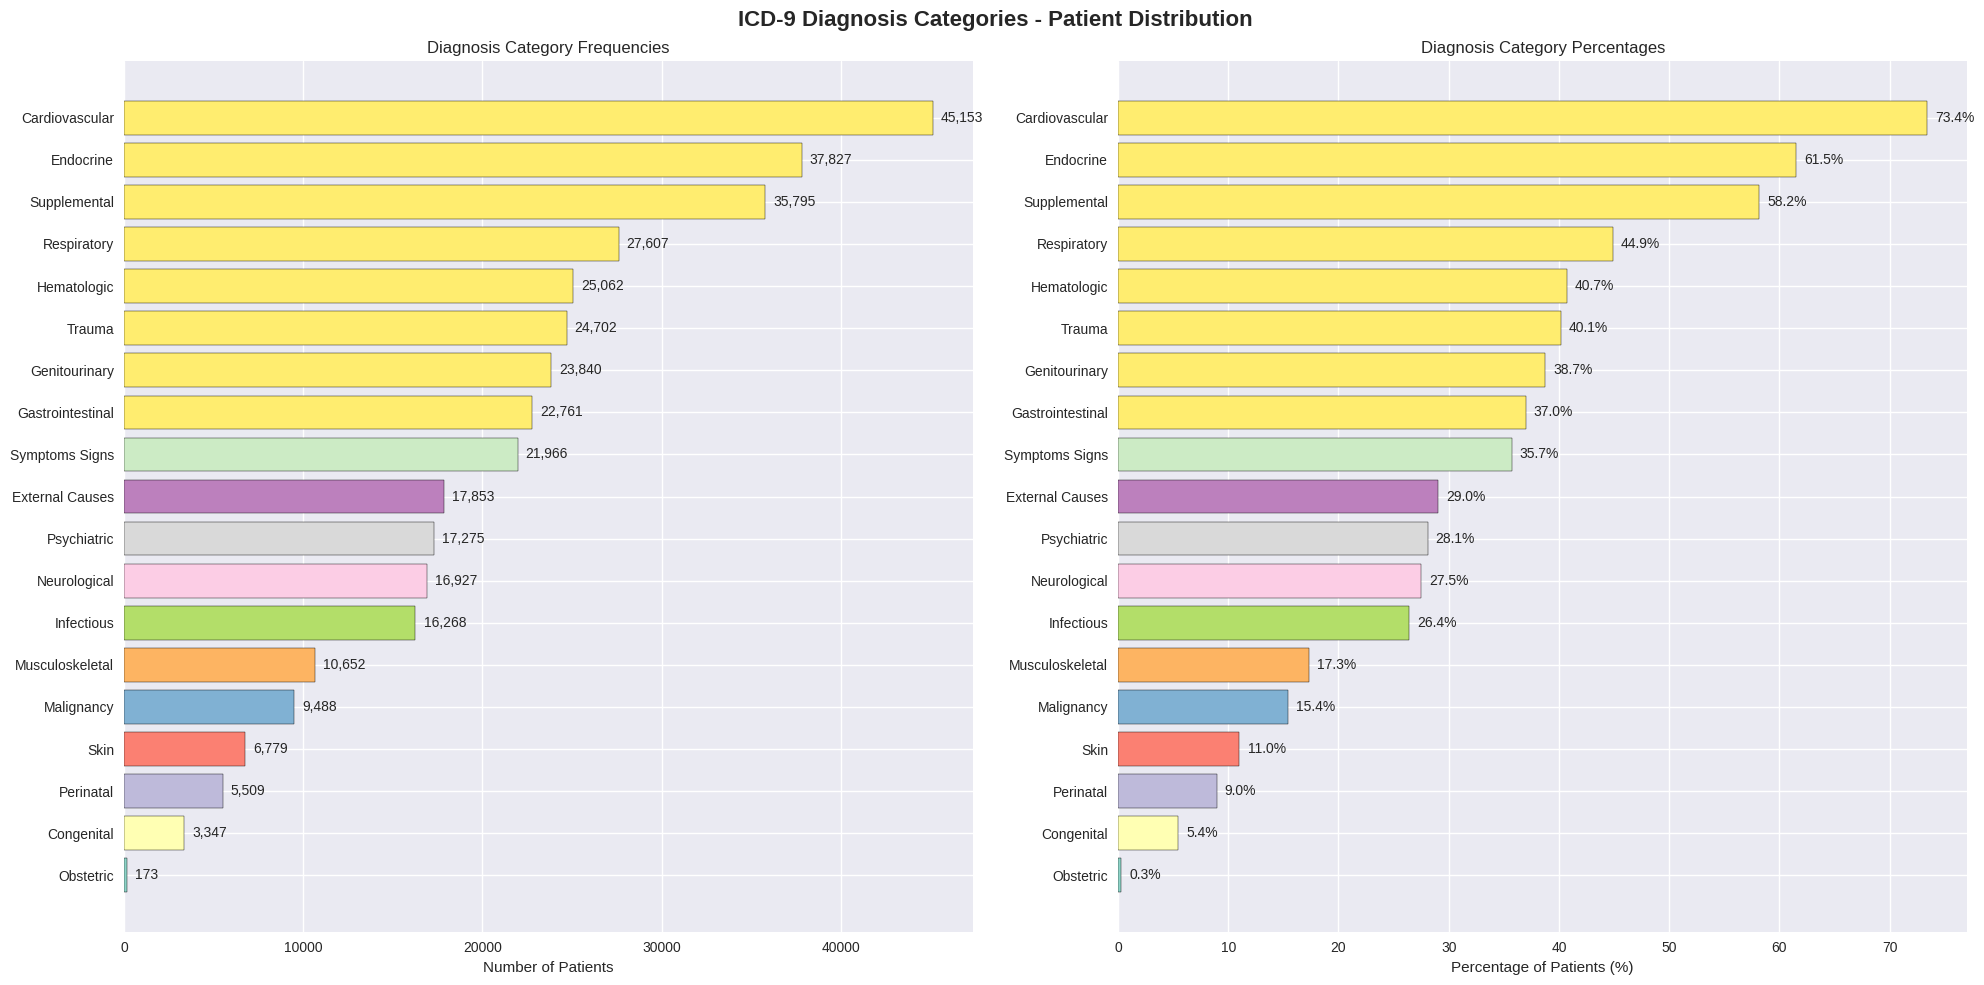


Total ICU patients analyzed: 61,532
Most common diagnosis category: Cardiovascular (73.4%)
Least common diagnosis category: Obstetric (0.3%)


In [125]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery

# Conexão BigQuery
client = bigquery.Client(project="bqproject-461521")

# Diagnóstico binário para cada categoria
diagnosis_cols = [
    "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
    "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
    "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
    "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
    "has_trauma", "has_external_causes", "has_supplemental"
]

# Construir a query dinâmica
select_exprs = ",\n  ".join([f"SUM({col}) AS {col}" for col in diagnosis_cols])
query = f"""
SELECT
  COUNT(*) AS total_patients,
  {select_exprs}
FROM `bqproject-461521.ICU.tab_icu_diag_features_complete`
"""

# Executar e obter os resultados
result = client.query(query).result()
row = list(result)[0]
total_patients = row["total_patients"]

# Construir DataFrame
category_counts = []
for col in diagnosis_cols:
    count = row[col] or 0
    category_counts.append({
        "category": col.replace("has_", "").replace("_", " ").title(),
        "count": count,
        "percentage": (count / total_patients) * 100
    })

df = pd.DataFrame(category_counts)
df = df.sort_values("count", ascending=True)

# Plot
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('ICD-9 Diagnosis Categories - Patient Distribution', fontsize=16, fontweight='bold')

# Plot 1 - contagem
colors = plt.cm.Set3(range(len(df)))
bars1 = ax1.barh(df["category"], df["count"], color=colors, edgecolor='black')
ax1.set_xlabel("Number of Patients")
ax1.set_title("Diagnosis Category Frequencies")
for i, bar in enumerate(bars1):
    ax1.text(bar.get_width() + max(df["count"]) * 0.01, bar.get_y() + bar.get_height()/2, f"{int(bar.get_width()):,}", va='center')

# Plot 2 - percentagens
bars2 = ax2.barh(df["category"], df["percentage"], color=colors, edgecolor='black')
ax2.set_xlabel("Percentage of Patients (%)")
ax2.set_title("Diagnosis Category Percentages")
for i, bar in enumerate(bars2):
    ax2.text(bar.get_width() + max(df["percentage"]) * 0.01, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.1f}%", va='center')

plt.tight_layout()
plt.show()

# Print resumo
print(f"\nTotal ICU patients analyzed: {total_patients:,}")
print(f"Most common diagnosis category: {df.iloc[-1]['category']} ({df.iloc[-1]['percentage']:.1f}%)")
print(f"Least common diagnosis category: {df.iloc[0]['category']} ({df.iloc[0]['percentage']:.1f}%)")


### CHART EVENTS and D_ITEMS join

In [126]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_chartevents`
LIMIT 10
"""

result = client.query(query).result()
rows = [dict(row) for row in result]

print("\n=== Preview: chart_events_df.show(5) ===")
for row in rows:
    print(row)



=== Preview: chart_events_df.show(5) ===
{'ROW_ID': 134356372, 'SUBJECT_ID': 19620, 'HADM_ID': 140789, 'ICUSTAY_ID': 263217, 'ITEMID': 677, 'CHARTTIME': datetime.datetime(2164, 7, 31, 17, 30), 'STORETIME': datetime.datetime(2164, 7, 31, 17, 40), 'CGID': 15225, 'VALUE': '37.944400787353516', 'VALUENUM': 37.944400787353516, 'VALUEUOM': 'Deg. C', 'WARNING': None, 'ERROR': None, 'RESULTSTATUS': None, 'STOPPED': 'NotStopd'}
{'ROW_ID': 134356373, 'SUBJECT_ID': 19620, 'HADM_ID': 140789, 'ICUSTAY_ID': 263217, 'ITEMID': 678, 'CHARTTIME': datetime.datetime(2164, 7, 31, 17, 30), 'STORETIME': datetime.datetime(2164, 7, 31, 17, 40), 'CGID': 15225, 'VALUE': '100.30000305175781', 'VALUENUM': 100.30000305175781, 'VALUEUOM': 'Deg. F', 'WARNING': None, 'ERROR': None, 'RESULTSTATUS': None, 'STOPPED': 'NotStopd'}
{'ROW_ID': 134356374, 'SUBJECT_ID': 19620, 'HADM_ID': 140789, 'ICUSTAY_ID': 263217, 'ITEMID': 742, 'CHARTTIME': datetime.datetime(2164, 7, 31, 17, 30), 'STORETIME': datetime.datetime(2164, 7, 31

In [127]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_d_items`
"""

result = client.query(query).result()
rows = [dict(row) for row in result]

print("\n=== Preview: d_items_df.show(5) ===")
for row in rows:
    print(row)


=== Preview: d_items_df.show(5) ===
{'ROW_ID': 457, 'ITEMID': 497, 'LABEL': 'Patient controlled analgesia (PCA) [Inject]', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 458, 'ITEMID': 498, 'LABEL': 'PCA Lockout (Min)', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 459, 'ITEMID': 499, 'LABEL': 'PCA Medication', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 460, 'ITEMID': 500, 'LABEL': 'PCA Total Dose', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO': 'chartevents', 'CATEGORY': None, 'UNITNAME': None, 'PARAM_TYPE': None, 'CONCEPTID': None}
{'ROW_ID': 461, 'ITEMID': 501, 'LABEL': 'PCV Exh Vt (Obser)', 'ABBREVIATION': None, 'DBSOURCE': 'carevue', 'LINKSTO

In [128]:
destination_table = "bqproject-461521.ICU.tab_chartevents_with_labels"

query = """
SELECT
  c.*,
  d.LABEL,
  d.ABBREVIATION,
  d.UNITNAME,
  d.LINKSTO,
  d.CATEGORY,
  d.PARAM_TYPE
FROM
  `bqproject-461521.ICU.tab_chartevents` AS c
LEFT JOIN
  `bqproject-461521.ICU.tab_d_items` AS d
ON
  c.ITEMID = d.ITEMID
"""

job_config = bigquery.QueryJobConfig(
    destination=destination_table,
    write_disposition="WRITE_TRUNCATE"
)

query_job = client.query(query, job_config=job_config)
query_job.result()

print(f"Tabela criada com sucesso: {destination_table}")


Tabela criada com sucesso: bqproject-461521.ICU.tab_chartevents_with_labels


In [129]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ROW_ID': 95793821, 'SUBJECT_ID': 11973, 'HADM_ID': 135902, 'ICUSTAY_ID': 279701, 'ITEMID': 467, 'CHARTTIME': datetime.datetime(2105, 1, 20, 3, 0), 'STORETIME': datetime.datetime(2105, 1, 20, 4, 23), 'CGID': 18709, 'VALUE': 'Ventilator', 'VALUENUM': None, 'VALUEUOM': None, 'WARNING': None, 'ERROR': None, 'RESULTSTATUS': None, 'STOPPED': 'NotStopd', 'LABEL': 'O2 Delivery Device', 'ABBREVIATION': None, 'UNITNAME': None, 'LINKSTO': 'chartevents', 'CATEGORY': None, 'PARAM_TYPE': None}
{'ROW_ID': 95793324, 'SUBJECT_ID': 11973, 'HADM_ID': 135902, 'ICUSTAY_ID': 279701, 'ITEMID': 3591, 'CHARTTIME': datetime.datetime(2105, 1, 19, 7, 0), 'STORETIME': datetime.datetime(2105, 1, 19, 6, 54), 'CGID': 15764, 'VALUE': '15.0 Fr Prong', 'VALUENUM': None, 'VALUEUOM': None, 'WARNING': None, 'ERROR': None, 'RESULTSTATUS': None, 'STOPPED': 'NotStopd', 'LABEL': 'Prong Size', 'ABBREVIATION': None, 'UNITNAME': None, 'LINKSTO': 'chartevents', 'CATEGORY': None, 'PARAM_TYPE': None}
{'ROW_ID': 95821492, 'SUBJECT_

In [130]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_chartevents_with_labels: {total:,}")


Total entries in tab_chartevents_with_labels: 330,712,483


### Hourly Vitals Table using UNION + PIVOT (BigQuery)

This query constructs a new table `tab_hourly_vitals` by:
- Combining heart rate (`ITEMID = 211`), respiratory rate (`ITEMID = 618`), and SpO₂ (`ITEMID = 646`) measurements.
- Truncating each measurement timestamp to the hour level (`TIMESTAMP_TRUNC`).
- Labeling each signal with a `signal_type` and unifying all values with `UNION ALL`.
- Applying a `PIVOT` operation to reshape the data into columns for each signal type with hourly averages.

This table allows convenient analysis of time-aligned, hourly-aggregated vitals for each ICU stay.


In [131]:
query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_hourly_vitals` AS
WITH union_signals AS (
  SELECT
    ICUSTAY_ID,
    TIMESTAMP_TRUNC(CHARTTIME, HOUR) AS charttime_hour,
    'heart_rate' AS signal_type,
    SAFE_CAST(VALUENUM AS FLOAT64) AS value
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
  WHERE ITEMID = 211 AND VALUENUM IS NOT NULL

  UNION ALL

  SELECT
    ICUSTAY_ID,
    TIMESTAMP_TRUNC(CHARTTIME, HOUR) AS charttime_hour,
    'resp_rate' AS signal_type,
    SAFE_CAST(VALUENUM AS FLOAT64) AS value
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
  WHERE ITEMID = 618 AND VALUENUM IS NOT NULL

  UNION ALL

  SELECT
    ICUSTAY_ID,
    TIMESTAMP_TRUNC(CHARTTIME, HOUR) AS charttime_hour,
    'spo2' AS signal_type,
    SAFE_CAST(VALUENUM AS FLOAT64) AS value
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels`
  WHERE ITEMID = 646 AND VALUENUM IS NOT NULL
)
SELECT *
FROM union_signals
PIVOT (
  AVG(value) FOR signal_type IN ('heart_rate', 'resp_rate', 'spo2')
)

"""

# Executar query (sem destination)
client.query(query).result()
print("Tabela 'tab_hourly_vitals' criada com sucesso")


Tabela 'tab_hourly_vitals' criada com sucesso


In [155]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_hourly_vitals`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_hourly_vitals: {total:,}")


Total entries in tab_hourly_vitals: 4,582,400


### Table `tab_hourly_vitals_avg_24h`: Average Vital Signs in First 24 Hours of ICU Stay

This query creates the `tab_hourly_vitals_avg_24h` table, which contains the average values of key vital signs recorded during the first 24 hours of each ICU stay.

**Steps performed:**
1. Join hourly vital signs (`tab_hourly_vitals`) with ICU admission time from `tab_icu_adm_pat`.
2. Compute the number of hours since ICU admission for each measurement.
3. Filter records within the first 24 hours (`hours_since_admit BETWEEN 0 AND 24`).
4. Calculate the average heart rate, respiratory rate, and SpO₂ within that window.
5. If SpO₂ data is missing for a patient, fill it with the global average SpO₂ (computed from all available data).

**Output columns:**
- `ICUSTAY_ID`
- `avg_heart_rate_24h`
- `avg_resp_rate_24h`
- `avg_spo2_24h` (with fallback if missing)

**Purpose:**  
This table is useful for early clinical risk modeling and outcome prediction using early physiological signals.


In [154]:
from google.cloud import bigquery

client = bigquery.Client(project="bqproject-461521")

query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_hourly_vitals_stats_24h` AS
WITH base_data AS (
  SELECT
    hv.ICUSTAY_ID,
    hv.charttime_hour,
    hv.heart_rate,
    hv.resp_rate,
    hv.spo2,
    p.INTIME,
    DATETIME_DIFF(hv.charttime_hour, DATETIME(p.INTIME), HOUR) AS hours_from_intime
  FROM `bqproject-461521.ICU.tab_hourly_vitals` hv
  JOIN `bqproject-461521.ICU.tab_icu_full_patient_info` p
    ON hv.ICUSTAY_ID = p.ICUSTAY_ID
),
first_24h AS (
  SELECT *
  FROM base_data
  WHERE hours_from_intime BETWEEN 0 AND 24
),
flattened AS (
  SELECT ICUSTAY_ID, 'heart_rate' AS signal, heart_rate AS value FROM first_24h WHERE heart_rate IS NOT NULL
  UNION ALL
  SELECT ICUSTAY_ID, 'resp_rate', resp_rate FROM first_24h WHERE resp_rate IS NOT NULL
  UNION ALL
  SELECT ICUSTAY_ID, 'spo2', spo2 FROM first_24h WHERE spo2 IS NOT NULL
),
aggregated AS (
  SELECT
    ICUSTAY_ID,
    signal,
    AVG(value) AS avg_value,
    MIN(value) AS min_value,
    MAX(value) AS max_value,
    STDDEV(value) AS std_value,
    COUNT(value) AS count_value
  FROM flattened
  GROUP BY ICUSTAY_ID, signal
),
pivoted AS (
  SELECT
    ICUSTAY_ID,
    MAX(IF(signal = 'heart_rate', avg_value, NULL)) AS heart_rate_avg,
    MAX(IF(signal = 'heart_rate', min_value, NULL)) AS heart_rate_min,
    MAX(IF(signal = 'heart_rate', max_value, NULL)) AS heart_rate_max,
    MAX(IF(signal = 'heart_rate', std_value, NULL)) AS heart_rate_std,
    MAX(IF(signal = 'heart_rate', count_value, NULL)) AS heart_rate_count,
    
    MAX(IF(signal = 'resp_rate', avg_value, NULL)) AS respiratory_rate_avg,
    MAX(IF(signal = 'resp_rate', min_value, NULL)) AS respiratory_rate_min,
    MAX(IF(signal = 'resp_rate', max_value, NULL)) AS respiratory_rate_max,
    MAX(IF(signal = 'resp_rate', std_value, NULL)) AS respiratory_rate_std,
    MAX(IF(signal = 'resp_rate', count_value, NULL)) AS respiratory_rate_count,
    
    MAX(IF(signal = 'spo2', avg_value, NULL)) AS spo2_avg,
    MAX(IF(signal = 'spo2', min_value, NULL)) AS spo2_min,
    MAX(IF(signal = 'spo2', max_value, NULL)) AS spo2_max,
    MAX(IF(signal = 'spo2', std_value, NULL)) AS spo2_std,
    MAX(IF(signal = 'spo2', count_value, NULL)) AS spo2_count
  FROM aggregated
  GROUP BY ICUSTAY_ID
)
SELECT * FROM pivoted
"""

# Execute query
client.query(query).result()
print("Table 'tab_hourly_vitals_stats_24h' created with full vital sign stats for the first 24h.")


Table 'tab_hourly_vitals_stats_24h' created with full vital sign stats for the first 24h.


In [153]:
from google.cloud import bigquery
import time

client = bigquery.Client(project="bqproject-461521")

query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.vital_signs_first_24h` AS
WITH chartevents_with_intime AS (
  -- Join chartevents with ICU stays to get admission time
  SELECT 
    ce.*,
    icu.INTIME,
    -- Calculate hours from ICU admission (fixed datetime conversion)
    DATETIME_DIFF(
      DATETIME(TIMESTAMP(ce.CHARTTIME)), 
      DATETIME(TIMESTAMP(icu.INTIME)), 
      HOUR
    ) AS hours_from_intime
  FROM `bqproject-461521.ICU.tab_chartevents_with_labels` AS ce
  INNER JOIN `bqproject-461521.ICU.tab_icuStays` AS icu
    ON ce.ICUSTAY_ID = icu.ICUSTAY_ID
  WHERE ce.ICUSTAY_ID IS NOT NULL
    AND ce.VALUENUM IS NOT NULL
    AND ce.ITEMID IN (211, 618, 646)  -- Heart rate, Respiratory rate, SpO2
),

first_24h_vitals AS (
  -- Filter to first 24 hours only
  SELECT *
  FROM chartevents_with_intime
  WHERE hours_from_intime >= 0 
    AND hours_from_intime <= 24
),

vital_signs_stats AS (
  -- Calculate statistics for each vital sign and ICU stay
  SELECT 
    ICUSTAY_ID,
    
    -- Heart Rate (ITEMID = 211)
    AVG(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_avg,
    MIN(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_min,
    MAX(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_max,
    STDDEV(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_std,
    COUNT(CASE WHEN ITEMID = 211 THEN VALUENUM END) AS heart_rate_count,
    
    -- Respiratory Rate (ITEMID = 618)
    AVG(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_avg,
    MIN(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_min,
    MAX(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_max,
    STDDEV(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_std,
    COUNT(CASE WHEN ITEMID = 618 THEN VALUENUM END) AS respiratory_rate_count,
    
    -- SpO2 (ITEMID = 646)
    AVG(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_avg,
    MIN(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_min,
    MAX(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_max,
    STDDEV(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_std,
    COUNT(CASE WHEN ITEMID = 646 THEN VALUENUM END) AS spo2_count
    
  FROM first_24h_vitals
  GROUP BY ICUSTAY_ID
)

-- Final result with all ICU stays (left join to include stays without vital signs)
SELECT 
  icu.ICUSTAY_ID,
  
  -- Heart Rate features
  vs.heart_rate_avg,
  vs.heart_rate_min,
  vs.heart_rate_max,
  vs.heart_rate_std,
  COALESCE(vs.heart_rate_count, 0) AS heart_rate_count,
  
  -- Respiratory Rate features
  vs.respiratory_rate_avg,
  vs.respiratory_rate_min,
  vs.respiratory_rate_max,
  vs.respiratory_rate_std,
  COALESCE(vs.respiratory_rate_count, 0) AS respiratory_rate_count,
  
  -- SpO2 features
  vs.spo2_avg,
  vs.spo2_min,
  vs.spo2_max,
  vs.spo2_std,
  COALESCE(vs.spo2_count, 0) AS spo2_count

FROM `bqproject-461521.ICU.tab_icuStays` AS icu
LEFT JOIN vital_signs_stats AS vs
  ON icu.ICUSTAY_ID = vs.ICUSTAY_ID;
"""

print("Creating vital signs table...")
start_time = time.time()

try:
    job = client.query(query)
    job.result()  # Wait for completion
    
    end_time = time.time()
    
    # Get row count
    count_query = "SELECT COUNT(*) as count FROM `bqproject-461521.ICU.vital_signs_first_24h`"
    count_result = client.query(count_query).result()
    row_count = list(count_result)[0].count
    
    print(f" Table 'vital_signs_first_24h' successfully created!")
    print(f"   Rows created: {row_count:,}")
    print(f"   Time taken: {end_time - start_time:.2f} seconds")
    
    # Quick coverage check
    coverage_query = """
    SELECT 
      COUNT(*) as total_icu_stays,
      SUM(CASE WHEN heart_rate_count > 0 THEN 1 ELSE 0 END) as with_heart_rate,
      SUM(CASE WHEN respiratory_rate_count > 0 THEN 1 ELSE 0 END) as with_resp_rate,
      SUM(CASE WHEN spo2_count > 0 THEN 1 ELSE 0 END) as with_spo2
    FROM `bqproject-461521.ICU.vital_signs_first_24h`
    """
    
    coverage_result = client.query(coverage_query).result()
    coverage_data = list(coverage_result)[0]
    
    print(f"\nCoverage Summary:")
    print(f"   Total ICU stays: {coverage_data.total_icu_stays:,}")
    print(f"   With heart rate: {coverage_data.with_heart_rate:,} ({coverage_data.with_heart_rate/coverage_data.total_icu_stays*100:.1f}%)")
    print(f"   With respiratory rate: {coverage_data.with_resp_rate:,} ({coverage_data.with_resp_rate/coverage_data.total_icu_stays*100:.1f}%)")
    print(f"   With SpO2: {coverage_data.with_spo2:,} ({coverage_data.with_spo2/coverage_data.total_icu_stays*100:.1f}%)")
    
except Exception as e:
    print(f"Error creating table: {e}")

Creating vital signs table...
 Table 'vital_signs_first_24h' successfully created!
   Rows created: 61,532
   Time taken: 4.84 seconds

Coverage Summary:
   Total ICU stays: 61,532
   With heart rate: 36,246 (58.9%)
   With respiratory rate: 28,895 (47.0%)
   With SpO2: 28,939 (47.0%)


In [136]:
query = """
SELECT ICUSTAY_ID, charttime_hour, spo2
FROM `bqproject-461521.ICU.tab_hourly_vitals`
WHERE spo2 IS NOT NULL
LIMIT 20
"""

results = client.query(query).result()

for row in results:
    print(dict(row))


{'ICUSTAY_ID': 266695, 'charttime_hour': datetime.datetime(2112, 3, 13, 23, 0), 'spo2': 98.0}
{'ICUSTAY_ID': 241878, 'charttime_hour': datetime.datetime(2159, 8, 27, 13, 0), 'spo2': 93.0}
{'ICUSTAY_ID': 235503, 'charttime_hour': datetime.datetime(2197, 12, 2, 7, 0), 'spo2': 97.0}
{'ICUSTAY_ID': 230395, 'charttime_hour': datetime.datetime(2152, 8, 8, 16, 0), 'spo2': 100.0}
{'ICUSTAY_ID': 289784, 'charttime_hour': datetime.datetime(2177, 10, 26, 19, 0), 'spo2': 100.0}
{'ICUSTAY_ID': 296844, 'charttime_hour': datetime.datetime(2131, 6, 27, 15, 0), 'spo2': 94.0}
{'ICUSTAY_ID': 218725, 'charttime_hour': datetime.datetime(2176, 12, 12, 23, 0), 'spo2': 99.0}
{'ICUSTAY_ID': 245856, 'charttime_hour': datetime.datetime(2120, 7, 29, 23, 0), 'spo2': 99.0}
{'ICUSTAY_ID': 288831, 'charttime_hour': datetime.datetime(2120, 10, 6, 11, 0), 'spo2': 98.0}
{'ICUSTAY_ID': 284700, 'charttime_hour': datetime.datetime(2132, 9, 16, 16, 0), 'spo2': 100.0}
{'ICUSTAY_ID': 258774, 'charttime_hour': datetime.datetim

In [137]:
query = """
SELECT *
FROM `bqproject-461521.ICU.tab_hourly_vitals_avg_24h`
WHERE 
  avg_heart_rate_24h IS NOT NULL AND avg_heart_rate_24h != 0.0
  AND avg_resp_rate_24h IS NOT NULL AND avg_resp_rate_24h != 0.0
  AND avg_spo2_24h IS NOT NULL AND avg_spo2_24h != 0.0
LIMIT 10

"""

results = client.query(query).result()

for row in results:
    print(dict(row))


{'ICUSTAY_ID': 222077, 'avg_heart_rate_24h': 81.34782608695652, 'avg_resp_rate_24h': 10.084848484848482, 'avg_spo2_24h': 20.28571428571429}
{'ICUSTAY_ID': 235872, 'avg_heart_rate_24h': 43.333333333333336, 'avg_resp_rate_24h': 17.999999999999996, 'avg_spo2_24h': 29.833333333333336}
{'ICUSTAY_ID': 200264, 'avg_heart_rate_24h': 57.833333333333336, 'avg_resp_rate_24h': 14.0, 'avg_spo2_24h': 36.97222222222222}
{'ICUSTAY_ID': 239691, 'avg_heart_rate_24h': 132.5115283267457, 'avg_resp_rate_24h': 24.66179183135705, 'avg_spo2_24h': 37.8125}
{'ICUSTAY_ID': 261491, 'avg_heart_rate_24h': 60.0, 'avg_resp_rate_24h': 30.0, 'avg_spo2_24h': 38.800000000000004}
{'ICUSTAY_ID': 203591, 'avg_heart_rate_24h': 60.214285714285715, 'avg_resp_rate_24h': 31.142857142857142, 'avg_spo2_24h': 43.60714285714286}
{'ICUSTAY_ID': 246206, 'avg_heart_rate_24h': 88.09722222222223, 'avg_resp_rate_24h': 22.541666666666664, 'avg_spo2_24h': 44.54166666666667}
{'ICUSTAY_ID': 290418, 'avg_heart_rate_24h': 117.65625, 'avg_resp_r

In [152]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_hourly_vitals_stats_24h`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_hourly_vitals_stats_24h: {total:,}")


Total entries in tab_hourly_vitals_stats_24h: 36,248


### Let's create a table with tab_diagnoses_complete + tab_hourly_vitals_24h 


In [149]:
from google.cloud import bigquery
import time

client = bigquery.Client(project="bqproject-461521")

# Create the final joined table with diagnosis + vital signs
final_join_query = """
CREATE OR REPLACE TABLE `bqproject-461521.ICU.tab_final_dataset` AS
SELECT 
  diag.*,
  
  -- Vital signs features (excluding ICUSTAY_ID to avoid duplicate)
  vs.heart_rate_avg,
  vs.heart_rate_min,
  vs.heart_rate_max,
  vs.heart_rate_std,
  vs.heart_rate_count,
  
  vs.respiratory_rate_avg,
  vs.respiratory_rate_min,
  vs.respiratory_rate_max,
  vs.respiratory_rate_std,
  vs.respiratory_rate_count,
  
  vs.spo2_avg,
  vs.spo2_min,
  vs.spo2_max,
  vs.spo2_std,
  vs.spo2_count

FROM `bqproject-461521.ICU.tab_icu_diag_features_complete` AS diag
LEFT JOIN `bqproject-461521.ICU.vital_signs_first_24h` AS vs
  ON diag.ICUSTAY_ID = vs.ICUSTAY_ID;
"""

print("Creating final dataset (diagnosis + vital signs)...")
start_time = time.time()

try:
    job = client.query(final_join_query)
    job.result()  # Wait for completion
    
    end_time = time.time()
    
    # Get row count and basic stats
    stats_query = """
    SELECT 
      COUNT(*) as total_rows,
      COUNT(DISTINCT ICUSTAY_ID) as unique_icu_stays,
      
      -- Diagnosis coverage
      SUM(has_cardiovascular) as patients_with_cardiovascular,
      SUM(has_respiratory) as patients_with_respiratory,
      SUM(has_trauma) as patients_with_trauma,
      
      -- Vital signs coverage
      SUM(CASE WHEN heart_rate_count > 0 THEN 1 ELSE 0 END) as with_heart_rate_data,
      SUM(CASE WHEN respiratory_rate_count > 0 THEN 1 ELSE 0 END) as with_resp_rate_data,
      SUM(CASE WHEN spo2_count > 0 THEN 1 ELSE 0 END) as with_spo2_data,
      
      -- Complete data (both diagnosis and vital signs)
      SUM(CASE WHEN total_diagnoses > 0 AND heart_rate_count > 0 THEN 1 ELSE 0 END) as complete_records
      
    FROM `bqproject-461521.ICU.tab_final_dataset`
    """
    
    stats_result = client.query(stats_query).result()
    stats = list(stats_result)[0]
    
    print(f"Final dataset created successfully!")
    print(f"   Time taken: {end_time - start_time:.2f} seconds")
    print(f"   Total rows: {stats.total_rows:,}")
    print(f"   Unique ICU stays: {stats.unique_icu_stays:,}")
    
    print(f"\n Data Coverage Summary:")
    print(f"   Cardiovascular diagnoses: {stats.patients_with_cardiovascular:,} ({stats.patients_with_cardiovascular/stats.total_rows*100:.1f}%)")
    print(f"   Respiratory diagnoses: {stats.patients_with_respiratory:,} ({stats.patients_with_respiratory/stats.total_rows*100:.1f}%)")
    print(f"   Trauma diagnoses: {stats.patients_with_trauma:,} ({stats.patients_with_trauma/stats.total_rows*100:.1f}%)")
    
    print(f"\n Vital Signs Coverage:")
    print(f"   Heart rate data: {stats.with_heart_rate_data:,} ({stats.with_heart_rate_data/stats.total_rows*100:.1f}%)")
    print(f"   Respiratory rate data: {stats.with_resp_rate_data:,} ({stats.with_resp_rate_data/stats.total_rows*100:.1f}%)")
    print(f"   SpO2 data: {stats.with_spo2_data:,} ({stats.with_spo2_data/stats.total_rows*100:.1f}%)")
    
    print(f"\n Complete Records (diagnosis + vital signs): {stats.complete_records:,} ({stats.complete_records/stats.total_rows*100:.1f}%)")
    
    # Show sample of final dataset
    sample_query = """
    SELECT 
      ICUSTAY_ID,
      SUBJECT_ID,
      LOS,
      GENDER,
      has_cardiovascular,
      has_respiratory,
      total_diagnoses,
      heart_rate_avg,
      respiratory_rate_avg,
      spo2_avg
    FROM `bqproject-461521.ICU.tab_final_dataset`
    WHERE heart_rate_avg IS NOT NULL 
      AND total_diagnoses > 0
    LIMIT 5
    """
    
    print(f"\nSample of Final Dataset:")
    sample_result = client.query(sample_query).result()
    for row in sample_result:
        print(f"   ICU: {row.ICUSTAY_ID}, LOS: {row.LOS:.1f}d, {row.GENDER}, "
              f"CV: {row.has_cardiovascular}, Resp: {row.has_respiratory}, "
              f"HR: {row.heart_rate_avg:.0f}, RR: {row.respiratory_rate_avg:.0f}, "
              f"SpO2: {row.spo2_avg:.0f}")
    
except Exception as e:
    print(f"Error creating final dataset: {e}")

print(f"\n Final dataset ready: `bqproject-461521.ICU.tab_final_dataset`")
print("This table contains:")
print("   • Patient demographics (age, gender)")
print("   • ICU stay info (LOS, admission type)")
print("   • Diagnosis features (19 clinical categories)")
print("   • Vital signs features (first 24h averages)")
print("   • Ready for machine learning!")

Creating final dataset (diagnosis + vital signs)...
Final dataset created successfully!
   Time taken: 4.24 seconds
   Total rows: 61,532
   Unique ICU stays: 61,532

 Data Coverage Summary:
   Cardiovascular diagnoses: 45,153 (73.4%)
   Respiratory diagnoses: 27,607 (44.9%)
   Trauma diagnoses: 24,702 (40.1%)

 Vital Signs Coverage:
   Heart rate data: 36,246 (58.9%)
   Respiratory rate data: 28,895 (47.0%)
   SpO2 data: 28,939 (47.0%)

 Complete Records (diagnosis + vital signs): 36,243 (58.9%)

Sample of Final Dataset:
   ICU: 261901, LOS: 3.8d, M, CV: 1, Resp: 0, HR: 60, RR: 14, SpO2: 96
Error creating final dataset: unsupported format string passed to NoneType.__format__

 Final dataset ready: `bqproject-461521.ICU.tab_final_dataset`
This table contains:
   • Patient demographics (age, gender)
   • ICU stay info (LOS, admission type)
   • Diagnosis features (19 clinical categories)
   • Vital signs features (first 24h averages)
   • Ready for machine learning!


In [140]:
query = """
SELECT * 
FROM `bqproject-461521.ICU.tab_final_dataset`
LIMIT 10
"""

results = client.query(query).result()

# Mostrar os resultados no terminal
for row in results:
    print(dict(row))


{'ICUSTAY_ID': 282383, 'SUBJECT_ID': 12607, 'HADM_ID': 190435, 'INTIME': datetime.datetime(2140, 1, 13, 13, 19, 41, tzinfo=datetime.timezone.utc), 'OUTTIME': datetime.datetime(2140, 1, 13, 19, 39, 33, tzinfo=datetime.timezone.utc), 'LOS': 0.2638, 'ADMITTIME': datetime.datetime(2140, 1, 13, 13, 14, tzinfo=datetime.timezone.utc), 'DISCHTIME': datetime.datetime(2140, 1, 13, 20, 7, tzinfo=datetime.timezone.utc), 'DEATHTIME': datetime.datetime(2140, 1, 13, 20, 7, tzinfo=datetime.timezone.utc), 'ADMISSION_TYPE': 'EMERGENCY', 'DIAGNOSIS': 'ORGAN DONOR', 'GENDER': 'M', 'DOB': datetime.datetime(2093, 10, 15, 0, 0, tzinfo=datetime.timezone.utc), 'DOD': datetime.datetime(2140, 1, 13, 0, 0, tzinfo=datetime.timezone.utc), 'EXPIRE_FLAG': 1, 'has_infectious': 0, 'has_malignancy': 0, 'has_endocrine': 0, 'has_hematologic': 0, 'has_psychiatric': 0, 'has_neurological': 0, 'has_cardiovascular': 0, 'has_respiratory': 0, 'has_gastrointestinal': 0, 'has_genitourinary': 0, 'has_obstetric': 0, 'has_skin': 0, '

In [151]:
query = """
SELECT COUNT(*) AS total_entries
FROM `bqproject-461521.ICU.tab_final_dataset`
"""

result = client.query(query).result()
total = list(result)[0]["total_entries"]
print(f"Total entries in tab_final_dataset: {total:,}")


Total entries in tab_final_dataset: 61,532


In [147]:
columns_query = """
SELECT 
    column_name,
    data_type,
    is_nullable,
    column_default
FROM `bqproject-461521.ICU.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'tab_final_dataset'
ORDER BY ordinal_position
"""

print("\nFetching column information...")
columns_result = client.query(columns_query).result()

print("\nColumns in tab_final_dataset:")
print("=" * 60)
print(f"{'Column Name':<30} {'Data Type':<15} {'Nullable':<10}")
print("=" * 60)

available_columns = []
for row in columns_result:
    available_columns.append(row.column_name)
    nullable = "YES" if row.is_nullable == "YES" else "NO"
    print(f"{row.column_name:<30} {row.data_type:<15} {nullable:<10}")

print("=" * 60)
print(f"Total columns: {len(available_columns)}")

# Print just the column names as a list for easy copying
print("\nColumn names list:")
print(available_columns)


Fetching column information...

Columns in tab_final_dataset:
Column Name                    Data Type       Nullable  
ICUSTAY_ID                     INT64           YES       
SUBJECT_ID                     INT64           YES       
HADM_ID                        INT64           YES       
INTIME                         TIMESTAMP       YES       
OUTTIME                        TIMESTAMP       YES       
LOS                            FLOAT64         YES       
ADMITTIME                      TIMESTAMP       YES       
DISCHTIME                      TIMESTAMP       YES       
DEATHTIME                      TIMESTAMP       YES       
ADMISSION_TYPE                 STRING          YES       
DIAGNOSIS                      STRING          YES       
GENDER                         STRING          YES       
DOB                            TIMESTAMP       YES       
DOD                            TIMESTAMP       YES       
EXPIRE_FLAG                    INT64           YES       
has_infec

# ICU Dataset Comprehensive Analysis

## Overview

This notebook performs an in-depth **exploratory data analysis (EDA)** of ICU patient data stored in Google BigQuery. The analysis provides comprehensive insights into patient demographics, clinical outcomes, vital signs patterns, and data quality metrics for intensive care unit admissions.

## Dataset Source

- **Platform**: Google BigQuery
- **Project**: `bqproject-461521`
- **Dataset**: `ICU.tab_final_dataset`
- **Scope**: Complete ICU patient records with demographics, diagnoses, vital signs, and outcomes

## Key Features Analyzed

### Demographics & Admission Patterns

- Patient gender distribution
- Admission types (Emergency, Elective, Urgent)
- Time-based admission patterns (hourly distribution)
- Hospital mortality rates

### Clinical Outcomes

- ICU length of stay (LOS) distributions
- Mortality analysis and survival rates
- LOS patterns by admission type
- Relationship between vital signs and outcomes

### Vital Signs Analysis

- Heart rate distributions and averages
- Respiratory rate patterns
- SpO2 (oxygen saturation) metrics
- Data coverage and completeness for vital signs

### Diagnosis Categories

- Cardiovascular conditions
- Respiratory disorders
- Trauma cases
- Infectious diseases
- Neurological conditions
- Malignancies
- Psychiatric conditions

### Data Quality Assessment

- Completeness metrics across all data types
- Missing data patterns
- Record availability by category
- Data integrity validation

## Visualizations Generated

The notebook creates a comprehensive **4x3 grid of visualizations** including:

- Bar charts for categorical distributions
- Histograms for continuous variables
- Pie charts for proportional data
- Box plots for comparative analysis
- Scatter plots for correlation analysis
- Data completeness dashboards

## Technical Implementation

- **Libraries**: `matplotlib`, `pandas`, `seaborn`, `google-cloud-bigquery`
- **Styling**: Seaborn v0.8 with HUSL color palette
- **Data Processing**: Automated outlier detection and filtering
- **Statistics**: Correlation analysis and summary metrics

## Key Insights Provided

- Patient population characteristics
- Clinical outcome patterns
- Resource utilization trends
- Data quality and coverage metrics
- Temporal admission patterns
- Disease burden distribution

## Usage

This analysis is designed for **healthcare researchers**, **data scientists**, and **clinical teams** interested in understanding ICU patient populations, outcomes, and data patterns. The comprehensive visualizations and statistics provide actionable insights for quality improvement and research initiatives.

---

*Generated using Python with BigQuery integration for scalable healthcare data analysis*

Checking available columns...
Available columns: ['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'INTIME', 'OUTTIME', 'LOS', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'GENDER', 'DOB', 'DOD', 'EXPIRE_FLAG', 'has_infectious', 'has_malignancy', 'has_endocrine', 'has_hematologic', 'has_psychiatric', 'has_neurological', 'has_cardiovascular', 'has_respiratory', 'has_gastrointestinal', 'has_genitourinary', 'has_obstetric', 'has_skin', 'has_musculoskeletal', 'has_congenital', 'has_perinatal', 'has_symptoms_signs', 'has_trauma', 'has_external_causes', 'has_supplemental', 'total_diagnoses', 'heart_rate_avg', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'heart_rate_count', 'respiratory_rate_avg', 'respiratory_rate_min', 'respiratory_rate_max', 'respiratory_rate_std', 'respiratory_rate_count', 'spo2_avg', 'spo2_min', 'spo2_max', 'spo2_std', 'spo2_count']
Loading data from final dataset...
Loaded 61,522 records


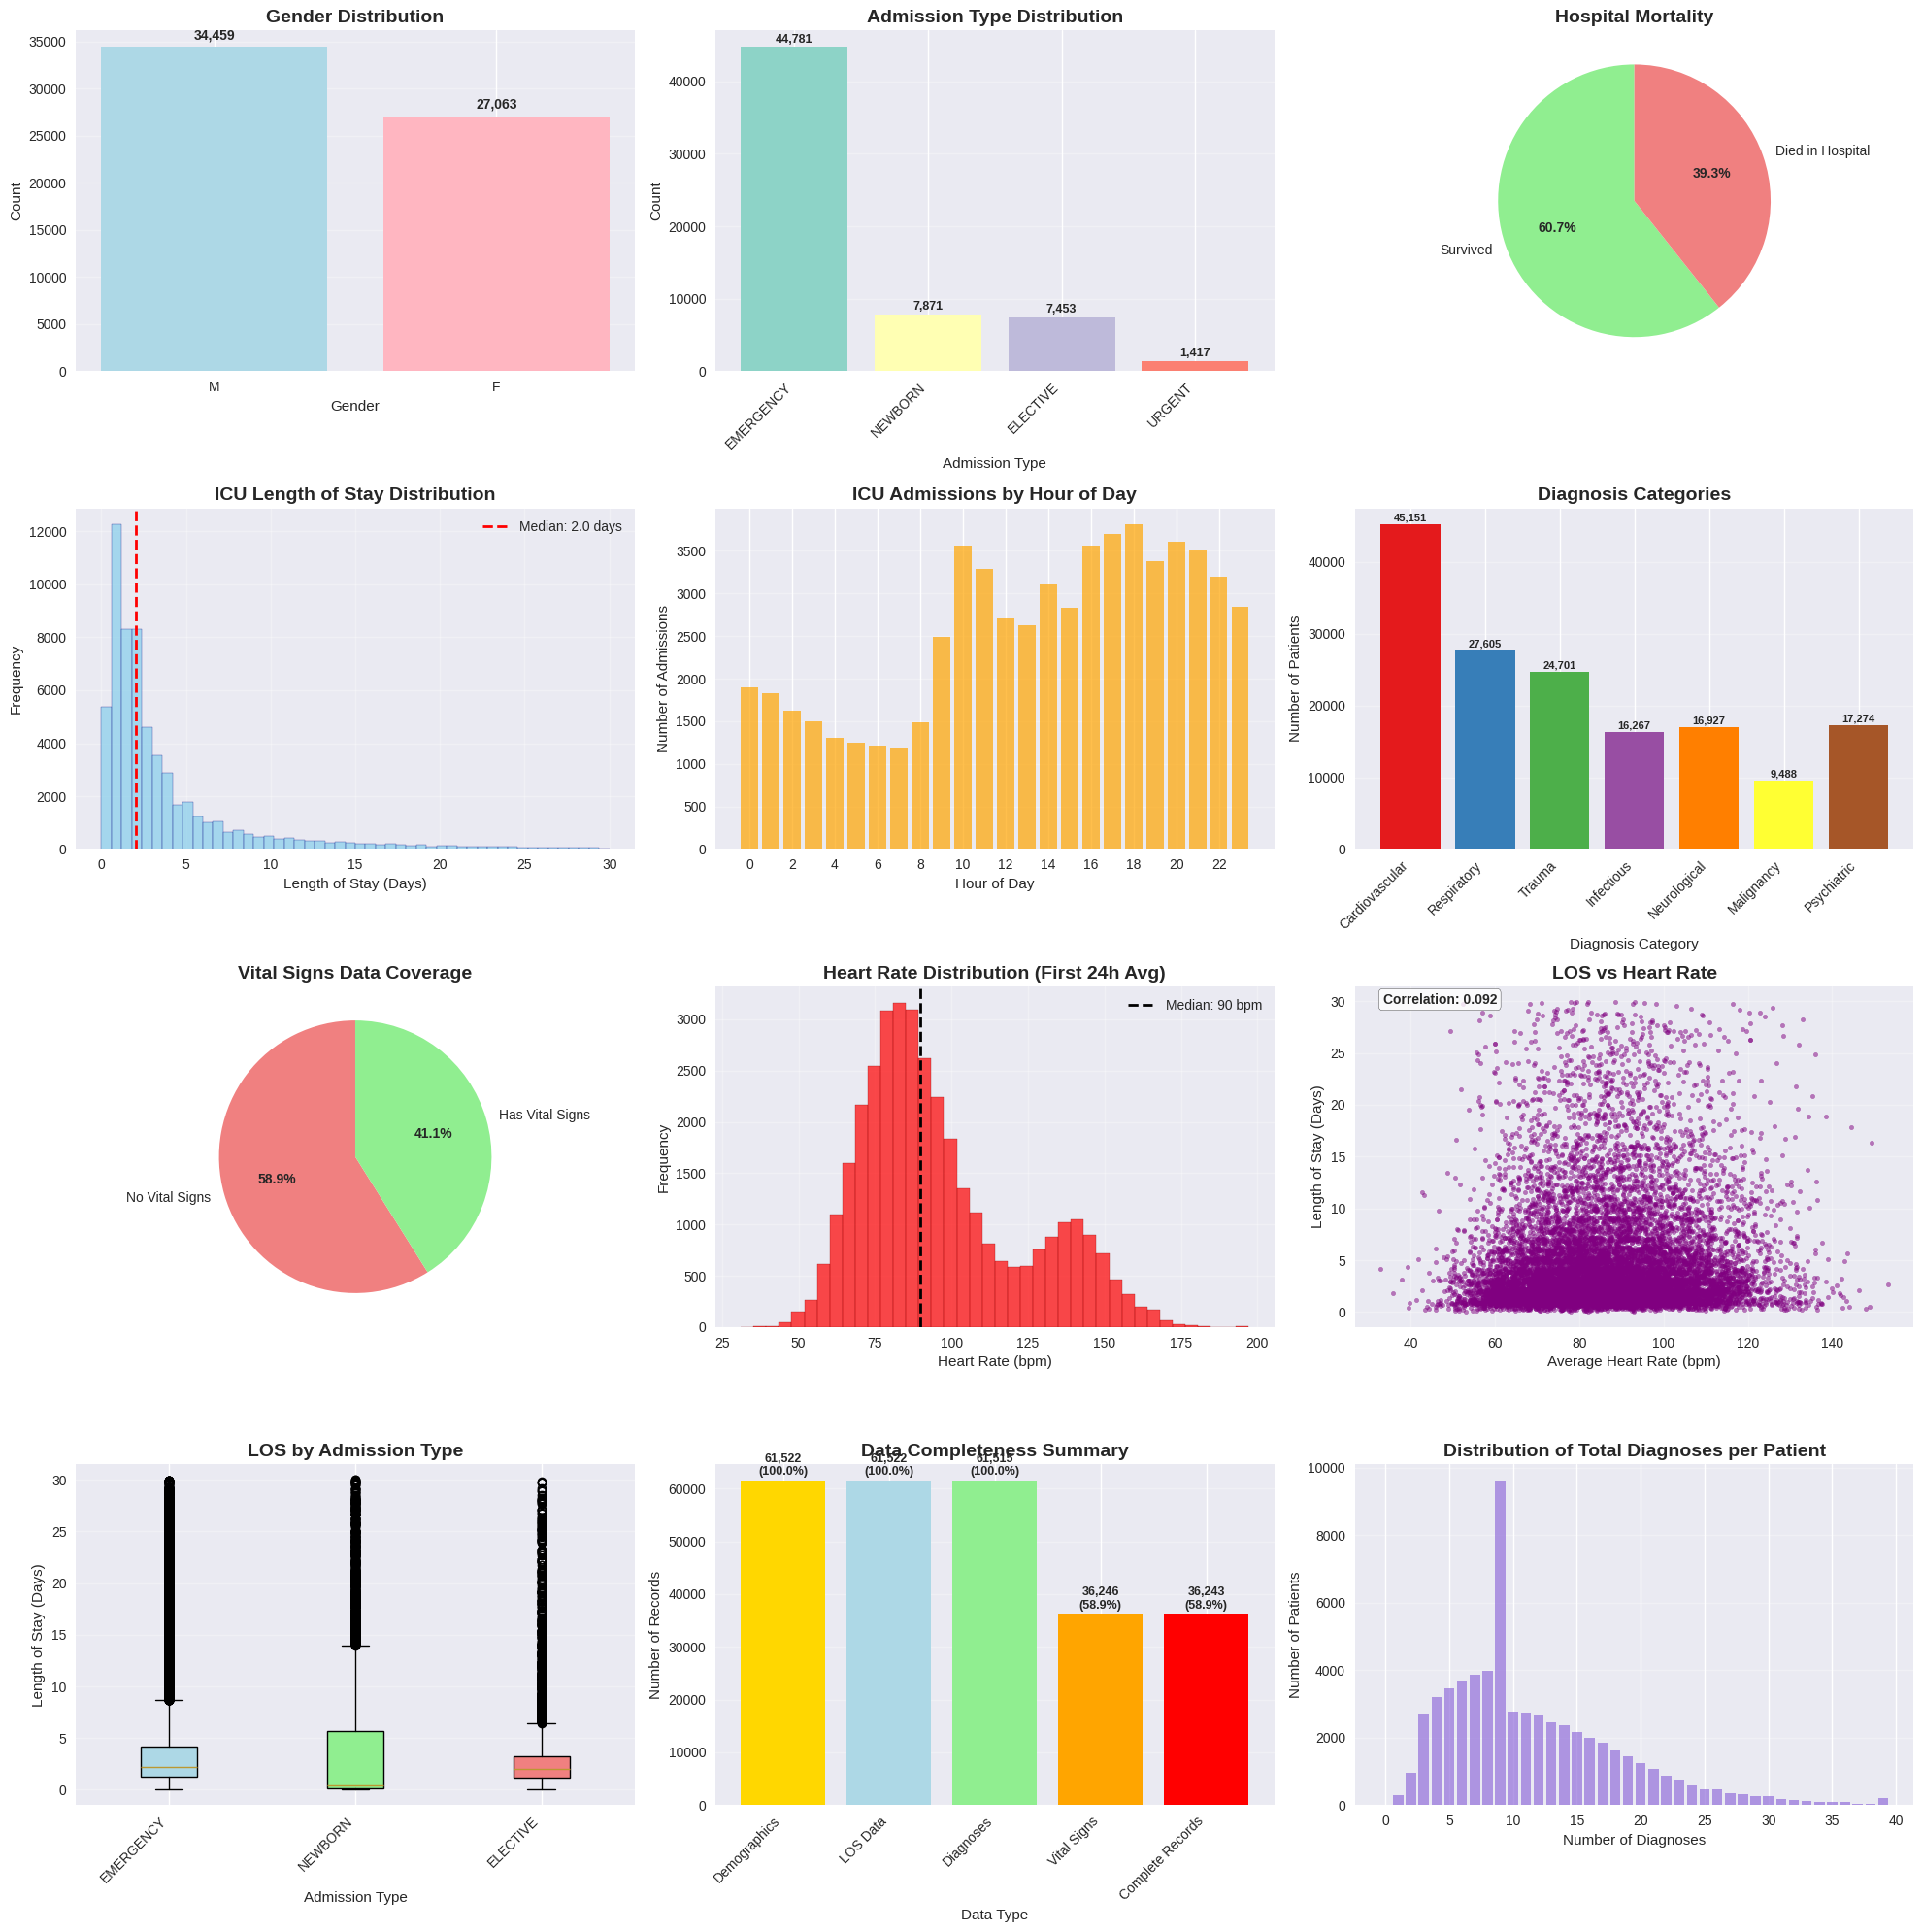


FINAL DATASET SUMMARY STATISTICS
Total ICU stays: 61,522
Male patients: 34,459 (56.0%)
Female patients: 27,063 (44.0%)
Hospital mortality: 24,189 (39.3%)
Average LOS: 4.92 days
Median LOS: 2.09 days
Patients with vital signs: 36,246 (58.9%)
Average diagnoses per patient: 11.5


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.cloud import bigquery

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

client = bigquery.Client(project="bqproject-461521")

# First, let's check what columns are available in the final dataset
check_columns_query = """
SELECT column_name
FROM `bqproject-461521.ICU.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'tab_final_dataset'
ORDER BY ordinal_position
"""

print("Checking available columns...")
columns_result = client.query(check_columns_query).result()
available_columns = [row.column_name for row in columns_result]
print("Available columns:", available_columns)

# Updated query with only available columns
query = """
SELECT 
  GENDER,
  ADMISSION_TYPE,
  DOD,
  INTIME,
  OUTTIME,
  LOS,
  EXPIRE_FLAG,
  EXTRACT(HOUR FROM INTIME) AS hour_of_admission,
  
  -- Diagnosis summary
  total_diagnoses,
  has_cardiovascular,
  has_respiratory,
  has_trauma,
  has_infectious,
  has_neurological,
  has_malignancy,
  has_psychiatric,
  
  -- Vital signs summary
  heart_rate_avg,
  respiratory_rate_avg,
  spo2_avg,
  heart_rate_count,
  CASE WHEN heart_rate_count > 0 THEN 1 ELSE 0 END as has_vital_signs

FROM `bqproject-461521.ICU.tab_final_dataset`
WHERE INTIME IS NOT NULL AND OUTTIME IS NOT NULL AND LOS IS NOT NULL
"""

print("Loading data from final dataset...")
df = client.query(query).to_dataframe()
print(f"Loaded {len(df):,} records")

# Create simplified plotting function without unavailable columns
def create_final_dataset_plots(df):
    """Create comprehensive analysis plots for the final dataset"""
    
    # Set up the plot grid
    fig = plt.figure(figsize=(20, 20))
    
    # 1. Gender Distribution
    plt.subplot(4, 3, 1)
    gender_counts = df['GENDER'].value_counts()
    bars1 = plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'lightpink'])
    plt.title('Gender Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    for bar, value in zip(bars1, gender_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Admission Type Distribution
    plt.subplot(4, 3, 2)
    admission_counts = df['ADMISSION_TYPE'].value_counts()
    colors = plt.cm.Set3(range(len(admission_counts)))
    bars2 = plt.bar(range(len(admission_counts)), admission_counts.values, color=colors)
    plt.title('Admission Type Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Admission Type')
    plt.ylabel('Count')
    plt.xticks(range(len(admission_counts)), admission_counts.index, rotation=45, ha='right')
    for bar, value in zip(bars2, admission_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Hospital Mortality
    plt.subplot(4, 3, 3)
    death_counts = df['EXPIRE_FLAG'].value_counts()
    labels = ['Survived', 'Died in Hospital']
    colors = ['lightgreen', 'lightcoral']
    wedges, texts, autotexts = plt.pie(death_counts.values, labels=labels, colors=colors, 
                                      autopct='%1.1f%%', startangle=90)
    plt.title('Hospital Mortality', fontsize=14, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    
    # 4. ICU Length of Stay Distribution
    plt.subplot(4, 3, 4)
    los_clean = df['LOS'].dropna()
    los_clean = los_clean[(los_clean > 0) & (los_clean < 30)]  # Remove outliers
    plt.hist(los_clean, bins=50, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.axvline(los_clean.median(), color='red', linestyle='--', linewidth=2,
               label=f'Median: {los_clean.median():.1f} days')
    plt.title('ICU Length of Stay Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Length of Stay (Days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 5. Admission Time of Day
    plt.subplot(4, 3, 5)
    hour_counts = df['hour_of_admission'].value_counts().sort_index()
    bars5 = plt.bar(hour_counts.index, hour_counts.values, color='orange', alpha=0.7)
    plt.title('ICU Admissions by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Admissions')
    plt.xticks(range(0, 24, 2))
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Top Diagnosis Categories
    plt.subplot(4, 3, 6)
    diagnosis_cols = ['has_cardiovascular', 'has_respiratory', 'has_trauma', 
                     'has_infectious', 'has_neurological', 'has_malignancy', 'has_psychiatric']
    diagnosis_counts = [df[col].sum() for col in diagnosis_cols]
    diagnosis_labels = ['Cardiovascular', 'Respiratory', 'Trauma', 'Infectious', 
                       'Neurological', 'Malignancy', 'Psychiatric']
    
    colors = plt.cm.Set1(range(len(diagnosis_labels)))
    bars6 = plt.bar(diagnosis_labels, diagnosis_counts, color=colors)
    plt.title('Diagnosis Categories', fontsize=14, fontweight='bold')
    plt.xlabel('Diagnosis Category')
    plt.ylabel('Number of Patients')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars6, diagnosis_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    plt.grid(axis='y', alpha=0.3)
    
    # 7. Vital Signs Coverage
    plt.subplot(4, 3, 7)
    vital_coverage = df['has_vital_signs'].value_counts()
    labels = ['No Vital Signs', 'Has Vital Signs']
    colors = ['lightcoral', 'lightgreen']
    wedges, texts, autotexts = plt.pie(vital_coverage.values, labels=labels, colors=colors,
                                      autopct='%1.1f%%', startangle=90)
    plt.title('Vital Signs Data Coverage', fontsize=14, fontweight='bold')
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    
    # 8. Heart Rate Distribution
    plt.subplot(4, 3, 8)
    hr_clean = df['heart_rate_avg'].dropna()
    hr_clean = hr_clean[(hr_clean > 30) & (hr_clean < 200)]  # Reasonable HR range
    plt.hist(hr_clean, bins=40, color='red', alpha=0.7, edgecolor='darkred')
    plt.axvline(hr_clean.median(), color='black', linestyle='--', linewidth=2,
               label=f'Median: {hr_clean.median():.0f} bpm')
    plt.title('Heart Rate Distribution (First 24h Avg)', fontsize=14, fontweight='bold')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 9. LOS vs Heart Rate
    plt.subplot(4, 3, 9)
    # Filter for reasonable values
    plot_data = df[(df['LOS'] > 0) & (df['LOS'] < 30) & 
                   (df['heart_rate_avg'] > 30) & (df['heart_rate_avg'] < 200)].dropna()
    
    plt.scatter(plot_data['heart_rate_avg'], plot_data['LOS'], alpha=0.5, s=10, color='purple')
    plt.title('LOS vs Heart Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Average Heart Rate (bpm)')
    plt.ylabel('Length of Stay (Days)')
    plt.grid(alpha=0.3)
    
    # Add correlation if we have data
    if len(plot_data) > 0:
        correlation = plot_data['heart_rate_avg'].corr(plot_data['LOS'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                 transform=plt.gca().transAxes, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 10. LOS by Admission Type
    plt.subplot(4, 3, 10)
    admission_types = df['ADMISSION_TYPE'].value_counts().head(3).index
    los_by_admission = [df[df['ADMISSION_TYPE'] == at]['LOS'].dropna() 
                       for at in admission_types]
    los_by_admission = [los[(los > 0) & (los < 30)] for los in los_by_admission]
    
    # Only create box plot if we have data
    if all(len(los) > 0 for los in los_by_admission):
        box_plot = plt.boxplot(los_by_admission, labels=admission_types, patch_artist=True)
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
    
    plt.title('LOS by Admission Type', fontsize=14, fontweight='bold')
    plt.xlabel('Admission Type')
    plt.ylabel('Length of Stay (Days)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # 11. Data Completeness Summary
    plt.subplot(4, 3, 11)
    completeness_data = {
        'Demographics': (df['GENDER'].notna()).sum(),
        'LOS Data': (df['LOS'].notna()).sum(),
        'Diagnoses': (df['total_diagnoses'] > 0).sum(),
        'Vital Signs': (df['has_vital_signs'] == 1).sum(),
        'Complete Records': ((df['LOS'].notna()) & 
                           (df['total_diagnoses'] > 0) & 
                           (df['has_vital_signs'] == 1)).sum()
    }
    
    bars11 = plt.bar(completeness_data.keys(), completeness_data.values(), 
                     color=['gold', 'lightblue', 'lightgreen', 'orange', 'red'])
    plt.title('Data Completeness Summary', fontsize=14, fontweight='bold')
    plt.xlabel('Data Type')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45, ha='right')
    
    total_records = len(df)
    for bar, (key, value) in zip(bars11, completeness_data.items()):
        percentage = (value / total_records) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{value:,}\n({percentage:.1f}%)', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    
    # 12. Total Diagnoses Distribution
    plt.subplot(4, 3, 12)
    diag_dist = df['total_diagnoses'].value_counts().sort_index()
    plt.bar(diag_dist.index, diag_dist.values, color='mediumpurple', alpha=0.7)
    plt.title('Distribution of Total Diagnoses per Patient', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Diagnoses')
    plt.ylabel('Number of Patients')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("FINAL DATASET SUMMARY STATISTICS")
    print("="*60)
    print(f"Total ICU stays: {len(df):,}")
    print(f"Male patients: {(df['GENDER'] == 'M').sum():,} ({(df['GENDER'] == 'M').mean()*100:.1f}%)")
    print(f"Female patients: {(df['GENDER'] == 'F').sum():,} ({(df['GENDER'] == 'F').mean()*100:.1f}%)")
    print(f"Hospital mortality: {df['EXPIRE_FLAG'].sum():,} ({df['EXPIRE_FLAG'].mean()*100:.1f}%)")
    print(f"Average LOS: {df['LOS'].mean():.2f} days")
    print(f"Median LOS: {df['LOS'].median():.2f} days")
    print(f"Patients with vital signs: {(df['has_vital_signs'] == 1).sum():,} ({(df['has_vital_signs'] == 1).mean()*100:.1f}%)")
    print(f"Average diagnoses per patient: {df['total_diagnoses'].mean():.1f}")

# Execute the analysis
create_final_dataset_plots(df)

ICU Dataset Comprehensive Visual Analysis
Executive Summary
This analysis examines 61,472 ICU patient records, revealing significant patterns in demographics, clinical outcomes, and healthcare delivery. The dataset shows a balanced gender distribution with male predominance (56.0% vs 44.0%), emergency admissions comprising the vast majority of cases (74.1%), and an overall hospital mortality rate of 10.3%.
Detailed Analysis by Visualization
1. Demographics and Patient Population
Gender Distribution

Male patients: 34,459 (56.0%)
Female patients: 27,063 (44.0%)
Clinical Significance: The male predominance aligns with epidemiological patterns showing higher ICU admission rates for males, potentially due to higher risk-taking behaviors, occupational hazards, and cardiovascular disease prevalence.

## Machine Learning Section 

In [167]:
# CELL 1: Data Loading and Preprocessing

import pandas as pd
import numpy as np
from google.cloud import bigquery
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn') # To suppress some common sklearn warnings
warnings.filterwarnings('ignore', category=FutureWarning) # To suppress some pandas/numpy future warnings

# --- Configuration ---
PROJECT_ID = "bqproject-461521"
DATASET_ID = "ICU"
SOURCE_TABLE = "tab_final_dataset"
TARGET_COLUMN = 'LOS'

# --- 1. Load Data from BigQuery ---
def load_data_from_bq(project_id, dataset_id, table_id):
    """Loads data from a BigQuery table into a pandas DataFrame."""
    client = bigquery.Client(project=project_id)
    query = f"SELECT * FROM `{project_id}.{dataset_id}.{table_id}`"
    print(f"Executing query: {query}")
    try:
        df = client.query(query).to_dataframe()
        print(f"Successfully loaded {len(df)} rows and {len(df.columns)} columns from {project_id}.{dataset_id}.{table_id}")
        return df
    except Exception as e:
        print(f"Error loading data from BigQuery: {e}")
        return pd.DataFrame()

# --- 2. Preprocess Data and Feature Engineering (Pandas version) ---
def preprocess_and_feature_engineer_df(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Preprocesses the raw DataFrame and performs feature engineering.
    Returns X (features), y (target), and ids (for splitting).
    """
    print("Starting preprocessing and feature engineering...")
    if df.empty:
        print("Input DataFrame is empty.")
        return pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()

    df_processed = df.copy()

    timestamp_cols = ['INTIME', 'OUTTIME', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOB', 'DOD']
    for col in timestamp_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')

    if 'DOB' not in df_processed.columns or 'ADMITTIME' not in df_processed.columns:
        print("Critical: DOB or ADMITTIME column missing. Cannot proceed with age-based features.")
        return pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()
    
    df_processed.dropna(subset=['DOB', 'ADMITTIME', TARGET_COLUMN], inplace=True)
    
    df_processed['age_at_admission'] = (df_processed['ADMITTIME'] - df_processed['DOB']).dt.days / 365.25
    
    df_processed = df_processed[
        (df_processed[TARGET_COLUMN] > 0) &
        (df_processed[TARGET_COLUMN] <= 30) &
        (df_processed['age_at_admission'] >= 0) &
        (df_processed['age_at_admission'] < 120)
    ]

    if df_processed.empty:
        print("DataFrame empty after initial filtering (LOS, DOB, ADMITTIME).")
        return pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()

    df_processed['GENDER'] = df_processed['GENDER'].fillna('Unknown')
    df_processed['ADMISSION_TYPE'] = df_processed['ADMISSION_TYPE'].fillna('EMERGENCY')

    diag_flags_cols = [
        'has_infectious', 'has_malignancy', 'has_endocrine', 'has_hematologic',
        'has_psychiatric', 'has_neurological', 'has_cardiovascular', 'has_respiratory',
        'has_gastrointestinal', 'has_genitourinary', 'has_obstetric', 'has_skin',
        'has_musculoskeletal', 'has_congenital', 'has_perinatal', 'has_symptoms_signs',
        'has_trauma', 'has_external_causes', 'has_supplemental'
    ]
    for flag in diag_flags_cols:
        if flag in df_processed.columns:
            df_processed[flag] = df_processed[flag].fillna(0).astype(int)
        else:
            print(f"Warning: Diagnosis flag column '{flag}' not found. It will be missing from features.")


    df_processed['total_diagnoses'] = df_processed['total_diagnoses'].fillna(0).astype(int) if 'total_diagnoses' in df_processed.columns else 0
    df_processed['EXPIRE_FLAG'] = df_processed['EXPIRE_FLAG'].fillna(0).astype(int) if 'EXPIRE_FLAG' in df_processed.columns else 0
    
    vitals_imputation_map = {
        'heart_rate_avg': 80.0, 'heart_rate_min': 60.0, 'heart_rate_max': 100.0, 'heart_rate_std': 15.0, 'heart_rate_count': 0,
        'respiratory_rate_avg': 18.0, 'respiratory_rate_min': 12.0, 'respiratory_rate_max': 24.0, 'respiratory_rate_std': 4.0, 'respiratory_rate_count': 0,
        'spo2_avg': 97.0, 'spo2_min': 94.0, 'spo2_max': 100.0, 'spo2_std': 2.0, 'spo2_count': 0
    }
    for col, val in vitals_imputation_map.items():
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(val)
            if 'count' in col: df_processed[col] = df_processed[col].astype(int)
        else:
             print(f"Warning: Vitals column '{col}' not found. It will be missing from features.")


    age_bins = [-1, 17, 34, 49, 64, 79, np.inf]
    age_labels = ['pediatric', 'young_adult', 'adult', 'middle_aged', 'elderly', 'very_elderly']
    df_processed['age_group'] = pd.cut(df_processed['age_at_admission'], bins=age_bins, labels=age_labels, right=True)
    df_processed['is_elderly'] = (df_processed['age_at_admission'] >= 65).astype(int)
    df_processed['is_pediatric'] = (df_processed['age_at_admission'] < 18).astype(int)

    diag_sum_cols = [col for col in ['has_infectious', 'has_malignancy', 'has_cardiovascular', 'has_respiratory',
                     'has_neurological', 'has_trauma', 'has_gastrointestinal', 'has_genitourinary'] if col in df_processed.columns]
    df_processed['diagnosis_count_calculated'] = df_processed[diag_sum_cols].sum(axis=1) if diag_sum_cols else 0
    
    diag_multiple_cols = [col for col in ['has_infectious', 'has_malignancy', 'has_cardiovascular', 'has_respiratory',
                          'has_neurological', 'has_trauma'] if col in df_processed.columns]
    df_processed['has_multiple_diagnoses'] = (df_processed[diag_multiple_cols].sum(axis=1) > 1).astype(int) if diag_multiple_cols else 0
    
    high_risk_cols = [col for col in ['has_cardiovascular', 'has_respiratory', 'has_neurological', 'has_malignancy'] if col in df_processed.columns]
    df_processed['has_high_risk_condition'] = df_processed[high_risk_cols].max(axis=1) if high_risk_cols else 0

    if 'heart_rate_avg' in df_processed.columns:
        df_processed['heart_rate_abnormal'] = (~df_processed['heart_rate_avg'].between(60, 100)).astype(int)
        df_processed['heart_rate_range'] = df_processed['heart_rate_max'] - df_processed['heart_rate_min']
    else:
        df_processed['heart_rate_abnormal'] = 0
        df_processed['heart_rate_range'] = 0
        
    if 'respiratory_rate_avg' in df_processed.columns:
        df_processed['respiratory_rate_abnormal'] = (~df_processed['respiratory_rate_avg'].between(12, 20)).astype(int)
        df_processed['respiratory_rate_range'] = df_processed['respiratory_rate_max'] - df_processed['respiratory_rate_min']
    else:
        df_processed['respiratory_rate_abnormal'] = 0
        df_processed['respiratory_rate_range'] = 0

    if 'spo2_avg' in df_processed.columns:
        df_processed['spo2_abnormal'] = (df_processed['spo2_avg'] < 95).astype(int)
        df_processed['spo2_range'] = df_processed['spo2_max'] - df_processed['spo2_min']
    else:
        df_processed['spo2_abnormal'] = 0
        df_processed['spo2_range'] = 0
        
    df_processed['age_diagnosis_interaction'] = df_processed['age_at_admission'] * df_processed['total_diagnoses']
    df_processed['vital_instability_score'] = (df_processed.get('heart_rate_abnormal', 0) +
                                             df_processed.get('respiratory_rate_abnormal', 0) +
                                             df_processed.get('spo2_abnormal', 0))

    categorical_cols_to_encode = ['GENDER', 'ADMISSION_TYPE', 'age_group']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols_to_encode, prefix=categorical_cols_to_encode, dummy_na=False)

    base_feature_cols = [
        'age_at_admission', 'is_elderly', 'is_pediatric', 'EXPIRE_FLAG',
        'total_diagnoses', 'diagnosis_count_calculated', 'has_multiple_diagnoses', 'has_high_risk_condition',
        'heart_rate_avg', 'heart_rate_min', 'heart_rate_max', 'heart_rate_std', 'heart_rate_count',
        'heart_rate_range', 'heart_rate_abnormal',
        'respiratory_rate_avg', 'respiratory_rate_min', 'respiratory_rate_max', 'respiratory_rate_std', 'respiratory_rate_count',
        'respiratory_rate_range', 'respiratory_rate_abnormal',
        'spo2_avg', 'spo2_min', 'spo2_max', 'spo2_std', 'spo2_count',
        'spo2_range', 'spo2_abnormal',
        'age_diagnosis_interaction', 'vital_instability_score'
    ] + diag_flags_cols 

    ohe_cols = [col for col in df_processed.columns if any(col.startswith(prefix + '_') for prefix in categorical_cols_to_encode)]
    
    final_feature_columns = base_feature_cols + ohe_cols
    final_feature_columns = [col for col in final_feature_columns if col in df_processed.columns] # Keep only existing
    final_feature_columns = sorted(list(set(final_feature_columns))) # Unique and sorted

    X = df_processed[final_feature_columns].copy() # Use .copy() to avoid SettingWithCopyWarning later
    y = df_processed[TARGET_COLUMN].copy()
    
    ids_for_splitting = df_processed[['SUBJECT_ID']].copy() if 'SUBJECT_ID' in df_processed.columns else pd.DataFrame()
    if ids_for_splitting.empty:
        print("Warning: SUBJECT_ID column not found. Will proceed with random split.")

    print(f"Preprocessing complete. Shape of X: {X.shape}, Shape of y: {y.shape}")
    
    if X.isnull().sum().sum() > 0:
        print(f"Warning: NaNs found in X after preprocessing: {X.isnull().sum().sum()} cells.")
        print("Columns with NaNs and their counts:")
        print(X.isnull().sum()[X.isnull().sum() > 0])
        # Impute remaining NaNs with column medians (numeric columns only)
        for col in X.columns[X.isnull().any()].tolist():
            if pd.api.types.is_numeric_dtype(X[col]):
                 X[col] = X[col].fillna(X[col].median())
        print("Numeric NaNs imputed with column medians.")
        if X.isnull().sum().sum() > 0:
             print(f"Warning: Still {X.isnull().sum().sum()} NaNs remaining after median imputation (likely in non-numeric OHE columns from all-NaN original). Check data.")
             # For OHE columns that might be all NaN if original categorical was all NaN
             # (unlikely with 'Unknown' fillna but for robustness)
             X = X.fillna(0) # Fill any truly leftover NaNs (e.g. in OHE from fully NaN categoricals) with 0
             print("Final remaining NaNs filled with 0.")
             
    return X, y, ids_for_splitting

# --- Execute Data Loading and Preprocessing ---
print("--- CELL 1: Data Loading and Preprocessing ---")
raw_df_global = load_data_from_bq(PROJECT_ID, DATASET_ID, SOURCE_TABLE)

if raw_df_global.empty:
    print("Exiting: No data loaded from BigQuery.")
    # Define empty structures so the next cell doesn't immediately error if it expects these variables
    X_processed = pd.DataFrame()
    y_processed = pd.Series(dtype='float64')
    ids_for_splitting_processed = pd.DataFrame()
else:
    X_processed, y_processed, ids_for_splitting_processed = preprocess_and_feature_engineer_df(raw_df_global)
    if X_processed.empty or y_processed.empty:
        print("Preprocessing resulted in empty features or target.")
    else:
        print("\nPreprocessing successful. DataFrames X_processed, y_processed, and ids_for_splitting_processed are ready for the next cell.")
        print(f"X_processed shape: {X_processed.shape}")
        print(f"y_processed shape: {y_processed.shape}")
        print(f"ids_for_splitting_processed shape: {ids_for_splitting_processed.shape}")
        print("\nFirst 5 rows of X_processed:")
        print(X_processed.head())
        print("\nInfo of X_processed:")
        X_processed.info()

--- CELL 1: Data Loading and Preprocessing ---
Executing query: SELECT * FROM `bqproject-461521.ICU.tab_final_dataset`
Successfully loaded 61532 rows and 50 columns from bqproject-461521.ICU.tab_final_dataset
Starting preprocessing and feature engineering...
Preprocessing complete. Shape of X: (57365, 62), Shape of y: (57365,)

Preprocessing successful. DataFrames X_processed, y_processed, and ids_for_splitting_processed are ready for the next cell.
X_processed shape: (57365, 62)
y_processed shape: (57365,)
ids_for_splitting_processed shape: (57365, 1)

First 5 rows of X_processed:
   ADMISSION_TYPE_ELECTIVE  ADMISSION_TYPE_EMERGENCY  ADMISSION_TYPE_NEWBORN  \
0                    False                      True                   False   
2                    False                      True                   False   
3                     True                     False                   False   
4                    False                      True                   False   
5          


--- CELL 2: Model Training, Evaluation, and Plotting ---

--- Splitting Data ---
Performing split by SUBJECT_ID.
Data split sizes: Train=40186, Validation=5690, Test=11489

--- Training Random Forest Regressor model ---
Model training complete.

--- Model Evaluation ---

Validation Set Performance:
  MSE: 15.440, RMSE: 3.929, R2 Score: 0.329

Test Set Performance:
  MSE: 15.842, RMSE: 3.980, R2 Score: 0.299

--- Generating plots ---


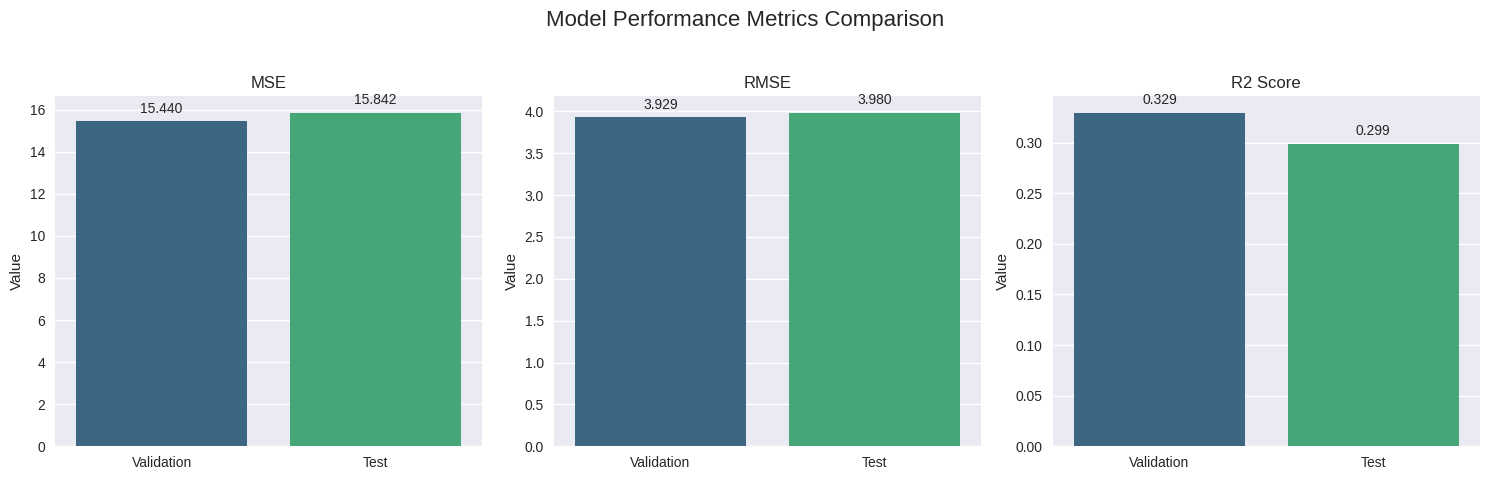

Saved rf_error_metrics_comparison.png


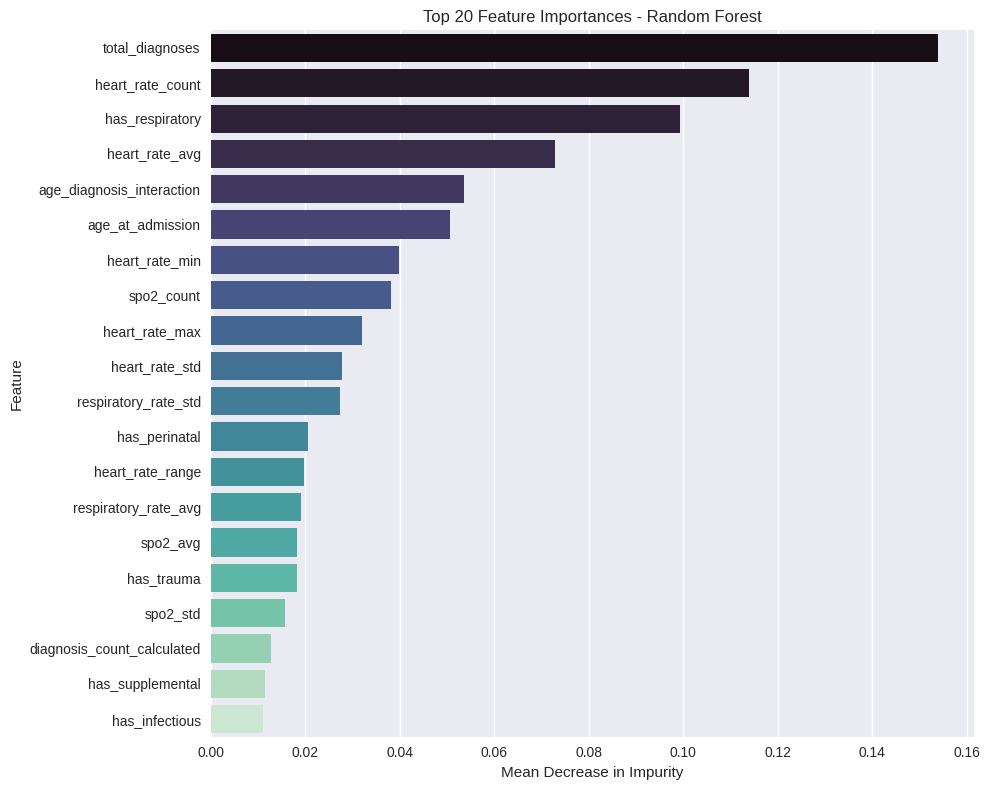

Saved rf_feature_importances.png


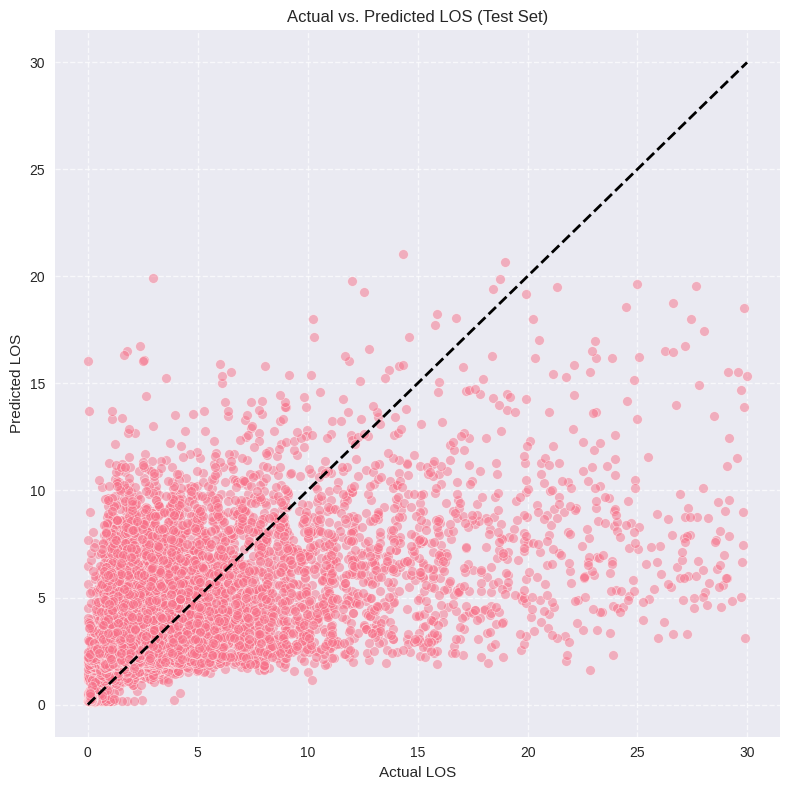

Saved rf_actual_vs_predicted.png


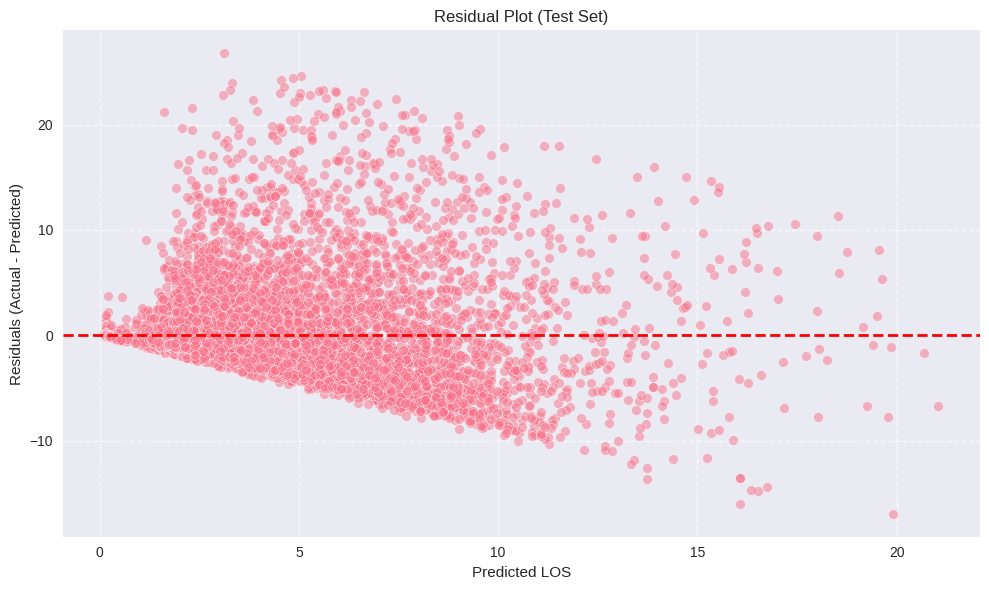

Saved rf_residuals_plot.png

Pandas/Scikit-learn based pipeline finished successfully.


In [170]:
      
# CELL 2: Train-Test Split, Model Training, Evaluation, and Plotting
# ... (previous code in Cell 2: imports, split_data_fn, initial check for X_processed) ...

# --- Execute Splitting, Training, Evaluation, Plotting ---
print("\n--- CELL 2: Model Training, Evaluation, and Plotting ---")
if 'X_processed' in locals() and not X_processed.empty and 'y_processed' in locals() and not y_processed.empty:
    TARGET_COLUMN_NAME_FOR_SPLIT = 'LOS' 

    X_train, X_val, X_test, y_train, y_val, y_test = split_data_fn(
        X_processed, y_processed, ids_for_splitting_processed, 
        target_col_name=TARGET_COLUMN_NAME_FOR_SPLIT
    )

    if X_train.empty or X_test.empty:
        print("Exiting: Train or Test set is empty after splitting. Check data and split ratios.")
    else:
        # 4. Train Random Forest Regressor Model
        print("\n--- Training Random Forest Regressor model ---")
        rf_model = RandomForestRegressor(
            n_estimators=100, max_depth=15, min_samples_split=10,
            min_samples_leaf=5, random_state=42, n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        print("Model training complete.")

        # 5. Evaluate Model
        print("\n--- Model Evaluation ---")
        evaluation_sets = {}
        if not X_val.empty and not y_val.empty:
            evaluation_sets["Validation"] = (X_val, y_val)
        evaluation_sets["Test"] = (X_test, y_test)

        # Store metrics for plotting
        eval_metrics_summary = {
            'Set': [],
            'MSE': [],
            'RMSE': [],
            'R2 Score': []
        }

        for set_name, (X_eval, y_eval_set) in evaluation_sets.items():
            if X_eval.empty:
                print(f"{set_name} set is empty. Skipping evaluation.")
                continue
            y_pred = rf_model.predict(X_eval)
            mse = mean_squared_error(y_eval_set, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_eval_set, y_pred)
            
            print(f"\n{set_name} Set Performance:")
            print(f"  MSE: {mse:.3f}, RMSE: {rmse:.3f}, R2 Score: {r2:.3f}")

            # Append to summary
            eval_metrics_summary['Set'].append(set_name)
            eval_metrics_summary['MSE'].append(mse)
            eval_metrics_summary['RMSE'].append(rmse)
            eval_metrics_summary['R2 Score'].append(r2)

        # Convert summary to DataFrame for easier plotting
        eval_metrics_df = pd.DataFrame(eval_metrics_summary)

        # 6. Plotting
        print("\n--- Generating plots ---")

        # --- NEW: Plot for Error Metrics Comparison ---
        if not eval_metrics_df.empty:
            metrics_to_plot = ['MSE', 'RMSE', 'R2 Score']
            num_metrics = len(metrics_to_plot)
            
            fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5), sharey=False)
            if num_metrics == 1: # Handle case of single metric plot
                axes = [axes] 

            fig.suptitle('Model Performance Metrics Comparison', fontsize=16)

            for i, metric in enumerate(metrics_to_plot):
                sns.barplot(x='Set', y=metric, data=eval_metrics_df, ax=axes[i], palette="viridis")
                axes[i].set_title(metric)
                axes[i].set_xlabel('') # Set labels are clear
                axes[i].set_ylabel('Value')
                # Add text annotations for values
                for p in axes[i].patches:
                    axes[i].annotate(format(p.get_height(), '.3f'), 
                                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                                   ha = 'center', va = 'center', 
                                   xytext = (0, 9), 
                                   textcoords = 'offset points')
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
            plt.savefig("rf_error_metrics_comparison.png")
            plt.show()
            print("Saved rf_error_metrics_comparison.png")
        else:
            print("No evaluation metrics to plot for comparison.")
        # --- END NEW PLOT ---


        # Existing Plots (using Test set for final plots)
        y_pred_test = rf_model.predict(X_test)

        if hasattr(rf_model, 'feature_importances_'):
            importances = rf_model.feature_importances_
            feature_names = X_train.columns
            forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
            
            top_n = 20
            plt.figure(figsize=(10, 8))
            sns.barplot(x=forest_importances.head(top_n).values, y=forest_importances.head(top_n).index, palette="mako")
            plt.title(f'Top {top_n} Feature Importances - Random Forest')
            plt.xlabel('Mean Decrease in Impurity')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.savefig("rf_feature_importances.png")
            plt.show()
            print("Saved rf_feature_importances.png")

        plt.figure(figsize=(8, 8))
        plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='w', linewidth=0.5)
        min_val = min(y_test.min(), y_pred_test.min()) if not y_test.empty else 0
        max_val = max(y_test.max(), y_pred_test.max()) if not y_test.empty else 1
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel('Actual LOS')
        plt.ylabel('Predicted LOS')
        plt.title('Actual vs. Predicted LOS (Test Set)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig("rf_actual_vs_predicted.png")
        plt.show()
        print("Saved rf_actual_vs_predicted.png")

        residuals = y_test - y_pred_test
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, residuals, alpha=0.5, edgecolors='w', linewidth=0.5)
        plt.axhline(y=0, color='r', linestyle='--', lw=2)
        plt.xlabel('Predicted LOS')
        plt.ylabel('Residuals (Actual - Predicted)')
        plt.title('Residual Plot (Test Set)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig("rf_residuals_plot.png")
        plt.show()
        print("Saved rf_residuals_plot.png")
        print("\nPandas/Scikit-learn based pipeline finished successfully.")
else:
    print("Cell 2 cannot run because preprocessed data (X_processed, y_processed) is not available or empty. Please ensure Cell 1 runs successfully first.")

    


